# EPM Moderators of Aging - Universal 450k Clock 

## Notebook Setup

In [2]:
import bisect
from collections import defaultdict, Counter
import math
import os
import pickle
import pkg_resources
from typing import Dict, List, Set, Tuple, Union
import sys
import warnings

from EpigeneticPacemaker.EpigeneticPacemaker import EpigeneticPacemaker
from EpigeneticPacemaker.EpigeneticPacemakerCV import EpigeneticPacemakerCV
from EPMTrait.DataHandlers import retrieve_sample_methylation, get_normalization_ref
from EPMTrait.QuantileNormalization import QuantileNormalizeSample
from EPMTrait.ModelHelpers import basic_func, fit_trend, get_age_bins, mae, pearson_correlation, r2
from EPMTrait.Plots import plot_known_predicted

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm

### Get Session Environment Information
- notebook environment 
    - Python 3.8.0 (default, Dec  5 2019, 19:17:49) [GCC 9.2.1 20191008]
    - EPMTrait 0.0.1
    - EpigeneticPacemaker 0.0.3
    - backcall 0.2.0
    - cffi 1.14.0
    - colorama 0.4.3
    - cycler 0.10.0
    - decorator 4.4.1
    - ipykernel 5.3.0
    - ipywidgets 7.6.3
    - jedi 0.17.2
    - joblib 1.0.1
    - kiwisolver 1.1.0
    - matplotlib 3.4.3
    - numexpr 2.7.1
    - numpy 1.21.1
    - pandas 1.3.1
    - parso 0.7.0
    - patsy 0.5.1
    - pexpect 4.7.0
    - pickleshare 0.7.5
    - psutil 5.7.0
    - ptyprocess 0.6.0
    - pyparsing 2.4.5
    - pytz 2019.3
    - scikit-learn 0.24.2
    - scipy 1.4.1
    - seaborn 0.11.1
    - simplejson 3.17.0
    - six 1.15.0
    - statsmodels 0.11.1
    - threadpoolctl 2.1.0
    - tornado 6.1
    - tqdm 4.62.2
    - traitlets 4.3.3
    - wcwidth 0.2.4

In [3]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [4]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

In [5]:
# filter warnings associated scipy.optimize trend fitting
warnings.filterwarnings("ignore", message="Covariance of the parameters could not be estimated")

### Set Plot Characteristics

In [6]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.usetex'] = False

### Import Reference Data

In [63]:
wd = ''
sample_meta_file = os.path.join(wd, 'processed_sample_meta.pkl')

In [8]:
with open(sample_meta_file, 'rb') as meta:
    sample_meta = pickle.load(meta)

In [9]:
k_ref = get_normalization_ref()

In [10]:
blood_450k_fit = np.poly1d(np.array([0.6673252 , 3.71840352]))

In [11]:
def sample_check(info, platform_id='GPL13534', tissue='blood', 
                 relative_intensity_filter=None,
                 med_res_max = 0.4, 
                 validation_exps={}):
    uMed_res_check = True
    if relative_intensity_filter:
        uMed_res_check = abs(info['proc_uMed'] - relative_intensity_filter(info['proc_mMed'])) < med_res_max
    check = [info['platform_id'] == platform_id, not info['proc_qc_fail'],
             info['proc_tissue'] == tissue, 'age yrs' in info,
             info['experiment_id'] not in validation_exps, uMed_res_check]
    return all(check)

In [12]:
# exlcude exps with multiple measurements of the same sample
excluded_exps = {'GSE105123', 'GSE74548', 'GSE140800', 'GSE151278'}

In [13]:
validation_exps = {'GSE61496', 'GSE107459', 'GSE51057', 'GSE111629', 'GSE142512', 'GSE128235', 
                   'GSE87640', 'GSE69138', 'GSE111165', 'GSE121633', 'GSE156994', 'GSE43976', 
                   'GSE140800', 'GSE74548', 'GSE87648', 'GSE125105', 'GSE51032', 'GSE73103', 
                   'GSE59065', 'GSE105123', 'GSE124366'}

In [14]:
blood_meta = {sample: info for sample, info in sample_meta.items() if 
              sample_check(info, validation_exps=validation_exps, relative_intensity_filter=blood_450k_fit) 
              and info['experiment_id'] not in excluded_exps}

In [15]:
blood_df = pd.DataFrame(blood_meta).T

In [16]:
Counter([info['experiment_id'] for info in blood_meta.values()])

Counter({'GSE87571': 727, 'GSE42861': 655, 'GSE97362': 123, 'GSE128064': 100})

In [17]:
blood_samples = list(blood_meta.keys())

### Train Test Split

In [18]:
ref_ages = np.array([sample['age yrs'] for sample in blood_meta.values()])

In [19]:
ref_sex = np.array([sample['proc_predictedSex'] for sample in blood_meta.values()])
ref_sex = np.array([1 if sex == 'F' else 0 for sex in ref_sex])

In [20]:
ref_exps = np.array([sample['experiment_id'] for sample in blood_meta.values()])

In [21]:
cell_types = ['proc_CD8T', 'proc_CD4T', 'proc_NK',
              'proc_Bcell','proc_Mono', 'proc_Gran']

In [22]:
ref_cells = []

for ct in cell_types:
    ref_cells.append([sample[ct] for sample in blood_meta.values()])

In [23]:
cell_pca = PCA(whiten=False).fit(np.array(ref_cells).T)
cell_pcs = cell_pca.transform(np.array(ref_cells).T)

In [24]:
ref_cells = pd.DataFrame(ref_cells, columns=blood_meta.keys(), index=cell_types).T

In [25]:
ref_cells['Age'] = ref_ages

In [26]:
for pc in range(cell_pcs.shape[1]):
    ref_cells[f'PC{pc + 1}'] = cell_pcs[:,pc]

In [27]:
def merge_bins(bins, min_bin_size=5):
    merged_bins = list(bins)
    while True:
        max_bin = max(merged_bins) - 1
        cleaned_bins = []
        bin_count = Counter(merged_bins)
        all_bins_merged = True
        for sample_bin in merged_bins:
            if bin_count[sample_bin] < min_bin_size:
                all_bins_merged = False
                if sample_bin < max_bin:
                    cleaned_bins.append(sample_bin + 1)
                else:
                    cleaned_bins.append(sample_bin - 1)
            else:
                cleaned_bins.append(sample_bin)
        merged_bins = cleaned_bins
        if all_bins_merged:
            break
    return np.array(merged_bins)       

In [28]:
def get_age_bins(ages, bin_number=20):
    binning = []
    interval = (max(ages) - min(ages)) / bin_number
    bin_ranges = [interval * x for x in range(bin_number)]
    for age in ages:
        binning.append(bisect.bisect_left(bin_ranges, age))
    return merge_bins(binning)

In [29]:
age_bins = get_age_bins(ref_ages, bin_number=20)

In [30]:
female_indices = [x for x, y in enumerate(zip(ref_sex, ref_exps)) if y[0] and y[1]]
female_bins = [age_bins[x] for x in female_indices]
male_indices = [x for x, y in enumerate(zip(ref_sex, ref_exps)) if y[0] == 0 and y[1]]
male_bins = [age_bins[x] for x in male_indices]

In [31]:
train_f, test_f = train_test_split(female_indices, stratify=female_bins, test_size=.05, random_state=1)
train_m, test_m = train_test_split(male_indices, stratify=male_bins, test_size=.05, random_state=1)

In [32]:
train_indices = train_f + train_m
test_indices = test_f + test_m

In [33]:
train_samples, test_samples = np.array(blood_samples)[train_indices], np.array(blood_samples)[test_indices]

In [64]:
processing_dir = f'{wd}'

In [65]:
def get_sample_matrix_info(sample_meta):
    sample_name = '_'.join(sample_meta["Grn"].split('_')[0:-1])
    file_prefix = f'{sample_meta["experiment_id"]}_{sample_meta["batch"]}'
    return f'\"{sample_name}\"', file_prefix

In [66]:
train_files = [get_sample_matrix_info(blood_meta[sample]) for sample in train_samples]
train_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in train_files}

In [67]:
if not os.path.exists('norm_ref.pkl'):
    train_methylation, train_header, train_rows = retrieve_sample_methylation(train_files, n_jobs=16, verbosity=10)
    norm_ref = dict(type_1=[], type_2=[])

    vals = {row: val for row, val in zip(train_rows, np.median(train_methylation, axis=1))}

    for probe_type, probes in k_ref.items():
        for pid in probes:
            try:
                norm_ref[probe_type].append(vals[pid])
            except KeyError:
                pass

    norm_ref['type_1'] = np.array(sorted(norm_ref['type_1']))
    norm_ref['type_2'] = np.array(sorted(norm_ref['type_2']))  

    with open('norm_ref.pkl', 'wb') as out:
        pickle.dump(norm_ref, out)

    del vals
    
else:
    with open('norm_ref.pkl', 'rb') as ref:
        norm_ref = pickle.load(ref)

In [68]:
train_sex, test_sex = ref_sex[train_indices], ref_sex[test_indices]

In [69]:
train_samples, test_samples = np.array(blood_samples)[train_indices], np.array(blood_samples)[test_indices]

In [70]:
train_ages, test_ages = ref_ages[train_indices], ref_ages[test_indices]

In [71]:
sample_exps = [sample_meta[sample]['experiment_id'] for sample in train_samples]

In [72]:
train_cells, test_cells = ref_cells.loc[train_samples], ref_cells.loc[test_samples]

### Load Training Data

In [73]:
train_files = [get_sample_matrix_info(blood_meta[sample]) for sample in train_samples]
train_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in train_files}

In [74]:
quant = QuantileNormalizeSample(normalization_reference=norm_ref, probe_ids=k_ref)

In [75]:
train_methylation, train_header, train_rows = retrieve_sample_methylation(train_files, n_jobs=16, verbosity=10, quantile_norm=quant)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  30 | elapsed:  2.5min remaining: 22.6min
[Parallel(n_jobs=16)]: Done   7 out of  30 | elapsed:  2.7min remaining:  8.9min
[Parallel(n_jobs=16)]: Done  11 out of  30 | elapsed:  2.8min remaining:  4.8min
[Parallel(n_jobs=16)]: Done  15 out of  30 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=16)]: Done  19 out of  30 | elapsed:  4.3min remaining:  2.5min
[Parallel(n_jobs=16)]: Done  23 out of  30 | elapsed:  4.6min remaining:  1.4min
[Parallel(n_jobs=16)]: Done  27 out of  30 | elapsed:  4.8min remaining:   32.1s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:  5.2min finished


In [76]:
cleaned_train_header = [x.replace('"', '').split('_')[0] for x in train_header][1:]

In [77]:
train_matrix =  pd.DataFrame(train_methylation, columns=cleaned_train_header, index=train_rows)

In [78]:
train_ages = np.array([blood_meta[sample]['age yrs'] for sample in list(train_matrix)])

In [79]:
sample_exps = [sample_meta[sample]['experiment_id'] for sample in list(train_matrix)]

In [80]:
train_sex = np.array([blood_meta[sample]['proc_predictedSex'] for sample in list(train_matrix)])
train_sex = np.array([1 if sex == 'F' else 0 for sex in train_sex])

In [81]:
train_cells = train_cells.loc[list(train_matrix)]

### Matrix QC

In [82]:
pca = PCA(whiten=False, n_components=10)
pcs = pca.fit_transform(train_matrix.values.T)

In [83]:
train_exps = [sample_meta[sample]['experiment_id'] for sample in cleaned_train_header]

In [84]:
exp_centers_1 = defaultdict(list)
exp_centers_2 = defaultdict(list)


for pc1, pc2, exp in zip(pcs[:, 0], pcs[:, 1], train_exps):
    exp_centers_1[exp].append(pc1)
    exp_centers_2[exp].append(pc2)

In [85]:
exp_centers = {}

for exp in exp_centers_1:
    exp_centers[exp] = (np.mean(exp_centers_1[exp]), np.mean(exp_centers_2[exp]))

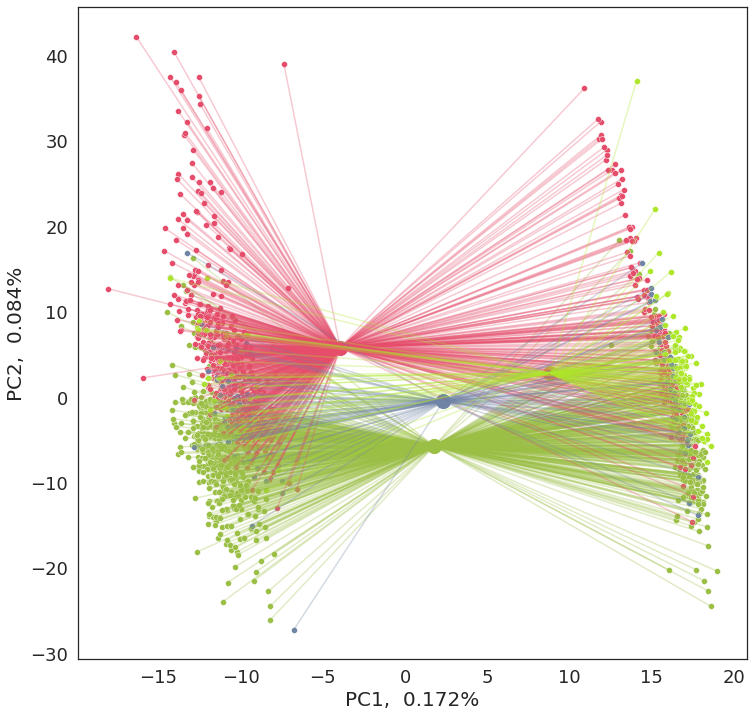

In [86]:
fig, ax = plt.subplots(figsize=(12,12))

for exp in exp_centers_1:
    color = list(np.random.rand(3,))
    x, y = exp_centers_1[exp], exp_centers_2[exp]
    center_x, center_y = np.mean(x), np.mean(y)
    sns.scatterplot(x=x, y=y, color=color)
    ax.scatter(center_x, center_y, s=200, color=color)
    for p_x, p_y in zip(x,y):
        plt.plot([p_x, center_x], [p_y, center_y], color=color, alpha=.3)

ax.set_xlabel(f'PC1, {pca.explained_variance_ratio_[0]: .3f}%')
ax.set_ylabel(f'PC2, {pca.explained_variance_ratio_[1]: .3f}%')

plt.show()

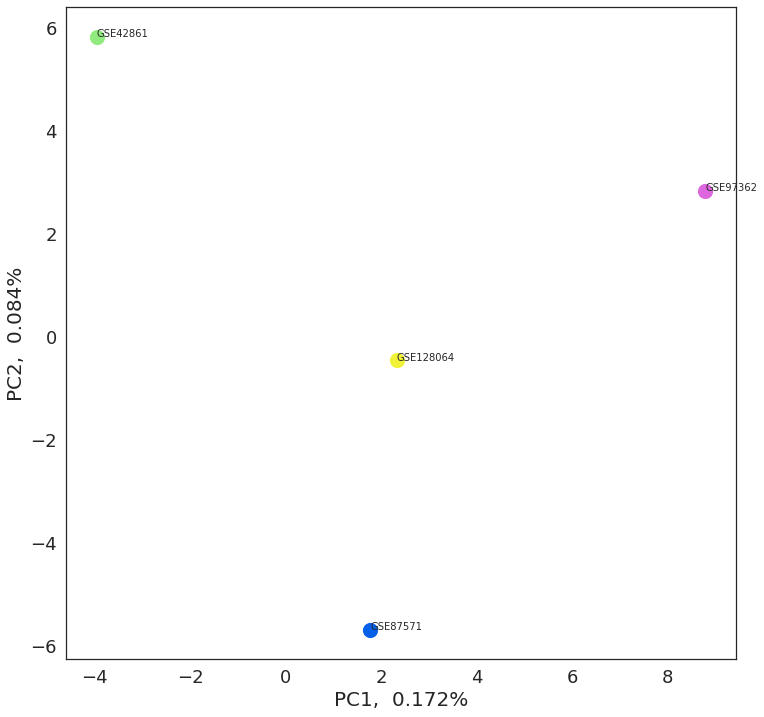

In [87]:
fig, ax = plt.subplots(figsize=(12,12))

for exp in exp_centers_1:
    color = list(np.random.rand(3,))
    x, y = exp_centers_1[exp], exp_centers_2[exp]
    center_x, center_y = np.mean(x), np.mean(y)
    #sns.scatterplot(x=x, y=y, color=color)
    ax.scatter(center_x, center_y, s=200, color=color)
    ax.text(center_x, center_y, exp)

ax.set_xlabel(f'PC1, {pca.explained_variance_ratio_[0]: .3f}%')
ax.set_ylabel(f'PC2, {pca.explained_variance_ratio_[1]: .3f}%')

plt.show()

### Fit Age LM 

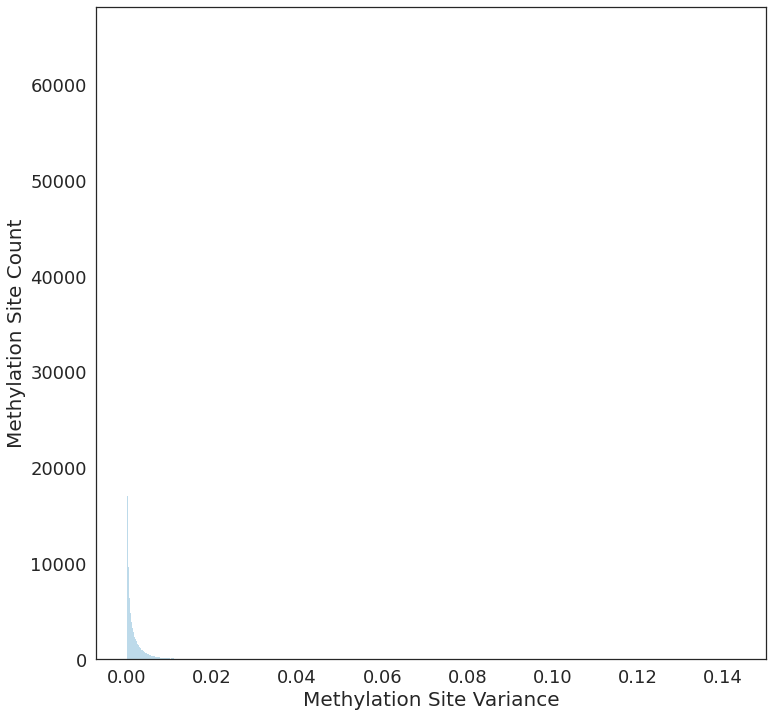

In [88]:
# check the per site variability across the training samples
# sites with low variablity will be removed before model fitting 
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(train_matrix.var(axis=1).values, ax=ax)
ax.set_xlabel('Methylation Site Variance')
ax.set_ylabel('Methylation Site Count')

plt.show()

In [89]:
lm_sites = [site[0] for site in (train_matrix.var(axis=1) > 0.001).to_dict().items() if site[1]]

In [90]:
def lin_func(x, a, b, c):
    return a * np.asarray(x) + c

In [91]:
def plot_lm(popt, ax, label='', hue=None, style=None, ages=None, eas=None):
    lm_r2 = r2(lin_func(ages, *popt), eas)
    fit_label = f'{label}  $f(x) = {popt[0]: .3f}x + {popt[2]: .3f}, R^2={lm_r2: .3f}$'
    sns.scatterplot(x=ages, y=eas, ax=ax, hue=hue, style=style)
    age_range = np.linspace(min(ages), max(ages), 100)
    expected_range = lin_func(age_range, *popt)
    ax.plot(age_range, expected_range, 'k--', lw=2, label=fit_label)
    ax.legend(fontsize=18, loc='upper left', frameon=False)
    ax.set_xlabel('Chronological Age (y)')
    ax.set_ylabel('Epigenetic Age (y)')
    return ax

In [92]:
def fit_lm(values, ages, en_kwargs):
    lm = ElasticNetCV(**en_kwargs)
    lm.fit(values.T, ages)
    predicted = lm.predict(values.T)
    return lm, predicted

In [93]:
def sparsify_lm(lm):
    sites = np.array([count for count, coef in enumerate(lm.coef_) if coef])
    model_coefs = lm.coef_[sites]
    intercept = lm.intercept_
    return sites, model_coefs, intercept

In [94]:
def get_sparse_model_predictions(values, sparse_lm):
    model_coefs, intercept = sparse_lm[1], sparse_lm[2]
    return np.dot(model_coefs, values) + intercept

In [97]:
default_en_kwargs = dict(alphas=None, l1_ratio=0.75, fit_intercept=True, 
                         precompute=False, max_iter=500, copy_X=True, 
                         tol=0.0001, positive=False, random_state=None, selection='random', cv=5, n_jobs=32,
                         verbose=1)

In [98]:
full_age_lm = fit_lm(train_matrix.loc[lm_sites].values, train_ages, default_en_kwargs)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 10.9min remaining: 16.4min
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 11.0min finished


In [99]:
sparse_full_lm = sparsify_lm(full_age_lm[0])

In [100]:
lm_labels = [lm_sites[count] for count, coef in enumerate(full_age_lm[0].coef_) if coef]

In [101]:
train_lm_predictions = get_sparse_model_predictions(train_matrix.loc[lm_labels].values, sparse_full_lm) 

In [102]:
full_lm_popt, _, _ = fit_trend(train_ages, train_lm_predictions, func=lin_func)

<Axes: xlabel='Chronological Age (y)', ylabel='Epigenetic Age (y)'>

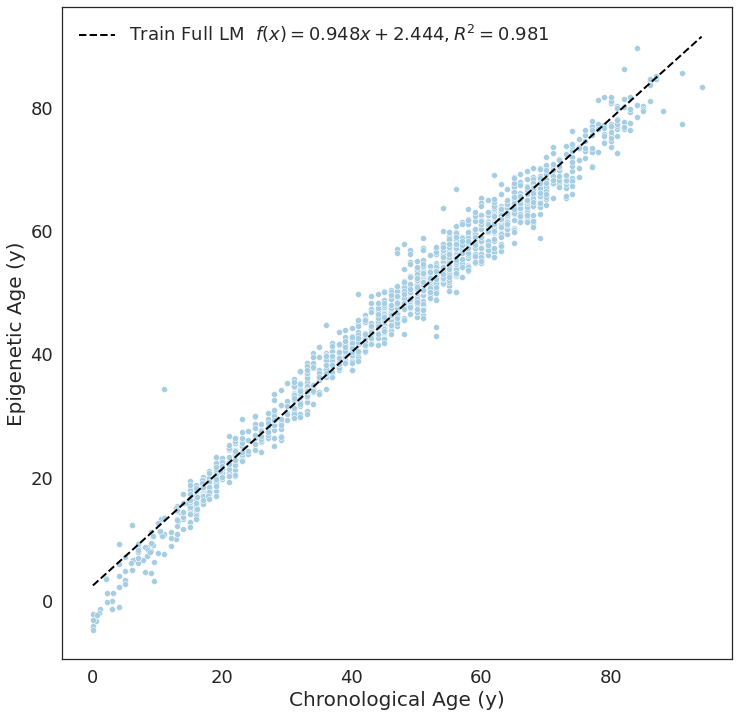

In [103]:
fig, ax = plt.subplots(figsize=(12,12))

plot_lm(full_lm_popt, ax, label='Train Full LM', ages=train_ages, eas=train_lm_predictions)

# EPM Fitting

### Subset Age Associated Sites

In [104]:
age_sites = np.where(abs(pearson_correlation(train_matrix.values, train_ages)) > .40)[0]

In [105]:
len(age_sites)

16880

### Subset Age / Sex Sites

In [106]:
age_site_labels = [train_matrix.index[index] for index in age_sites]

In [107]:
epm_matrix = train_matrix.loc[age_site_labels]

### Site Characterization 

In [108]:
def get_expected(values, coefs):
    return np.sum([values * coef for coef in coefs[:-1]], axis=0) + coefs[-1]

In [109]:
def get_ss_state(expected_meth_values, coefs):
    '''Only work with 1st degree linear model'''
    return (expected_meth_values - coefs[1]) / coefs[0]

In [110]:
def fit_linear_model(meth_values, ages, degrees=1, label=None):
    coefs = np.polyfit(ages, meth_values, degrees)
    predicted_meth = get_expected(ages, coefs)
    r = stats.pearsonr(predicted_meth, meth_values)[0]
    mae = np.mean(abs(predicted_meth - meth_values))
    std = np.std(abs(predicted_meth - meth_values))
    fit_label = label if label else degrees
    return {f'{fit_label}r':r, f'{fit_label}mae': mae, 
            f'{fit_label}coefs': coefs, 
            f'{fit_label}predicted_meth': predicted_meth,
            f'{fit_label}std': std}

In [111]:
def characterize_site(meth_values, ages, trait=np.array([]), linear_fits=2):
    site_info = {}
    site_info['range'] = max(meth_values) - min(meth_values)
    site_info['mean'] = np.mean(meth_values)
    site_info['variance'] = np.var(meth_values)
    site_info['std'] = np.std(meth_values)
    site_info['r'] = stats.pearsonr(meth_values, ages)[0]
    if len(trait) > 1:
        site_info['trait_r'] = stats.pearsonr(meth_values, trait)[0]
    for model in range(linear_fits):
        results = fit_linear_model(meth_values, ages, model + 1)
        site_info.update(results)
        if model + 1 == 1:
            states = get_ss_state(results['1predicted_meth'], results['1coefs'])
            ss_results = fit_linear_model(meth_values, states, 1, '1ss')
            site_info['1states'] = states
    return site_info

In [112]:
def get_fit_label(coefs):
    model_parts = [f'{coef:.5f}' for coef in coefs[::-1]]
    cleaned_model = [model_parts[0], f'{model_parts[1]}x']
    if len(model_parts) > 2:
        for count, part in enumerate(model_parts[2:]):
            cleaned_model.append(f'{part}x^{count + 2}')
    return f'f(x) = {"+".join(cleaned_model)}'

In [113]:
def plot_site(meth_values, ages, coefs, mae, ax, color='k'):
    fit_label = get_fit_label(coefs)
    plot_ages = np.linspace(min(ages), max(ages), 1000)
    ax.plot(plot_ages, get_expected(plot_ages, coefs), f'{color}--', label=f'${fit_label},MAE={mae: .4f}$')
    ax.scatter(ages, meth_values, marker='o', alpha=0.8, color=color)
    ax.set_xlabel('Age')
    ax.set_ylabel('beta')
    ax.legend()

### Modeling Site Variation
- samples with no age acceleration should show primarily technical variation 
- sample with age acceleration should have a mix of technical and biological variation 
- $\hat{m_i} = m_i^0 + r_js_{i} + \epsilon_{i,j}$
    - $\epsilon_{i,j} = \epsilon_{b,i,j} + \epsilon_{t,i,j}$
    - minimize shared $\epsilon_{b,i,j}$

In [114]:
sites_info = {}

for count, site in tqdm(enumerate(epm_matrix.values)):
    sites_info[count] = characterize_site(site, train_ages, train_sex, linear_fits=1)

0it [00:00, ?it/s]

In [115]:
## calculate deviation from fit

sample_error = []
epm_sites = []

for site, site_info in sites_info.items():
    if site_info['1mae'] > .025:
        continue
    epm_sites.append(epm_matrix.index[site])
    meth_values = epm_matrix.values[site, :]
    predicted_meth = site_info['1predicted_meth']
    sample_error.append((meth_values - predicted_meth))
    
sample_error = np.array(sample_error)

In [116]:
len(epm_sites)

7013

In [117]:
epm_matrix = epm_matrix.loc[epm_sites]

### Cluster Similar Sites
- simulate *phenotypes* based on shared variation amongst similar sites 

In [118]:
def ap_cluster_meth_sites(site_values, cluster_preference=5):
    af = AffinityPropagation(preference=cluster_preference, random_state=1)
    af.fit(site_values)
    labels = defaultdict(list)
    for site_index, site_label in enumerate(af.labels_):
        labels[site_label].append(site_index)
    return af, labels, {count:center for count, center in enumerate(af.cluster_centers_indices_)}

In [119]:
cluster_fit, site_labels, cluster_centers = ap_cluster_meth_sites(sample_error, cluster_preference=-2.5)

In [120]:
def get_site_pcs(site_values):
    pca = PCA(whiten=False, n_components=10)
    pcs = pca.fit_transform(site_values)
    return pcs, pca.explained_variance_ratio_

In [121]:
def plot_af_cluster(x, y, site_labels, cluster_centers, ax=None, size_filter=0):
    for cluster_label, cluster_center in tqdm(cluster_centers.items()):
        cluster_sites = site_labels[cluster_label]
        if len(cluster_sites) < size_filter:
            continue
        color = list(np.random.rand(3,))
        center_x, center_y = x[cluster_center], y[cluster_center]
        cluster_x, cluster_y = x[cluster_sites], y[cluster_sites]
        ax.scatter(x=cluster_x, y=cluster_y, 
                   color=color, alpha=.5)
        ax.scatter(x=center_x, y=center_y,
                   s=200, color=color, alpha=.7)
        for site_x, site_y in zip(cluster_x, cluster_y):
            ax.plot([site_x, center_x], [site_y, center_y], color=color, lw=2, alpha=.3)
    return ax

In [122]:
train_pcs, train_pcs_var = get_site_pcs(sample_error)

  0%|          | 0/57 [00:00<?, ?it/s]

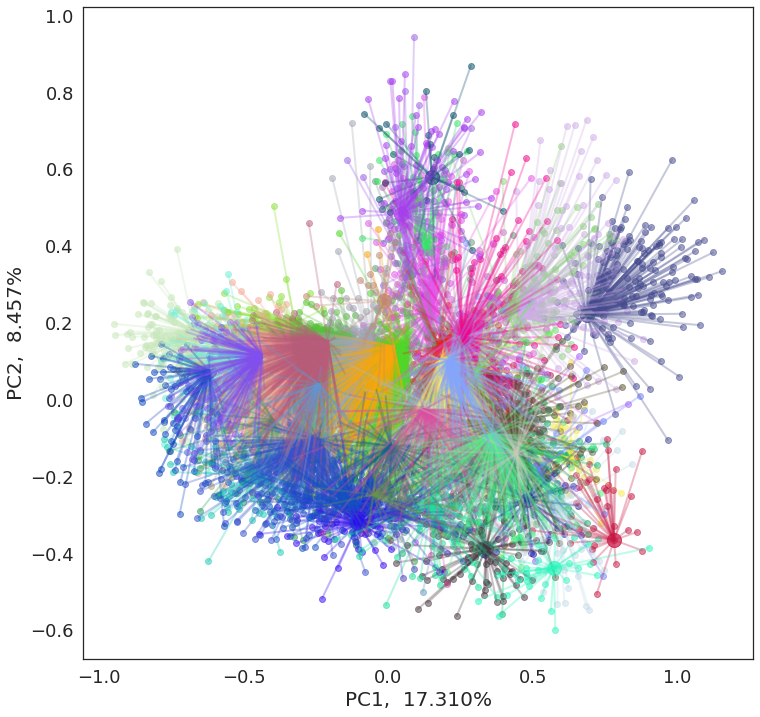

In [123]:
fig, ax = plt.subplots(figsize=(12,12))

plot_af_cluster(train_pcs[:, 0], train_pcs[:, 2], site_labels, cluster_centers, ax=ax)

ax.set_xlabel(f'PC1, {train_pcs_var[0] * 100: .3f}%')
ax.set_ylabel(f'PC2, {train_pcs_var[1] * 100: .3f}%')
plt.show()

### Cluster EPMs 

In [124]:
def fit_epm(values, ages) -> Tuple[EpigeneticPacemaker, np.ndarray]:
    epm = EpigeneticPacemakerCV(cv_folds=10)
    epm.fit(values, ages)
    states = epm.predict(values)
    return epm, states

In [125]:
def poly_fit(ages, states, degree=2):
    return np.polyfit(np.array(ages), np.array(states), degree)

In [126]:
def poly_predict_states(ages, poly):
    p = np.poly1d(poly)
    return p(ages)

In [127]:
epm = EpigeneticPacemakerCV(cv_folds=10)
epm.fit(epm_matrix.values, train_ages)
epm_states = epm.predict(epm_matrix.values)
epm_popt, _, expected_states = fit_trend(train_ages, epm_states)
epm_r2 = r2(epm_states, expected_states)
epm_mae = mae(epm_states, expected_states)
epm_poly = poly_fit(train_ages, epm_states)
epm_poly_expected = poly_predict_states(train_ages, epm_poly)

In [128]:
epm_r2, epm_mae

(0.7361783911509127, 8.93194285308862)

In [129]:
def plot_age_state_trends(summaries, ax, r2_filter=None):
    age_range = np.linspace(0,100, 100)
    for summary in summaries.values():
        if r2_filter:
            if summary['poly_r2'] < r2_filter:
                continue
        expected_range = poly_predict_states(age_range, summary['cluster_poly'])
        ax.plot(age_range, expected_range, 'k--', lw=2)
    return ax

In [130]:
def plot_epm(cluster_epm_info, cluster_epm_stats, ax, cluster_label='', cluster_hue=None, cluster_style=None, ages=None, states=None):
    clust_r2 = r2(basic_func(ages, *cluster_epm_info['popt']), states)
    fit_label = f'{cluster_label}  $f(x) = {cluster_epm_info["popt"][0]: .3f}x^{{0.5}} {cluster_epm_info["popt"][2]: .3f}, R^2={clust_r2: .3f}$'
    sns.scatterplot(x=ages, y=states, ax=ax, hue=cluster_hue, style=cluster_style)
    age_range = np.linspace(min(ages), max(ages), 100)
    expected_range = basic_func(age_range, *cluster_epm_info['popt'])
    ax.plot(age_range, expected_range, 'k--', lw=2, label=fit_label)
    ax.legend(fontsize=18, loc='upper left', frameon=False)
    ax.set_xlabel('Chronological Age (y)')
    ax.set_ylabel('State')
    return ax

In [135]:
default_en_kwargs = dict(alphas=None, l1_ratio=0.75, fit_intercept=True, 
                         precompute=False, max_iter=3000, copy_X=True, 
                         tol=0.0001, positive=False, random_state=None, selection='random', cv=5, n_jobs=16,
                         verbose=0)

In [136]:
cluster_epms = {}

for cluster, cluster_sites in tqdm(site_labels.items()):
    if len(cluster_sites) < 10:
        continue
    cluster_epm, cluster_states = fit_epm(epm_matrix.values[cluster_sites,:], train_ages)
    cluster_popt, _, expected = fit_trend(train_ages, cluster_states, func=basic_func)
    cluster_poly = poly_fit(train_ages, cluster_states, degree=2)
    cluster_poly_expected = poly_predict_states(train_ages, cluster_poly)
    clust_lm, lm_clust_values = fit_lm(train_matrix.values[cluster_sites,:], train_ages, default_en_kwargs)
    cluster_epms[cluster] = dict(epm=cluster_epm, states=cluster_states, 
                                 expected_states=expected, popt=cluster_popt,
                                 r2=r2(cluster_states, expected),
                                 mae=mae(cluster_states, expected),
                                 cluster_size=len(cluster_sites),
                                 cluster_poly=cluster_poly, cluster_poly_expected=cluster_poly_expected,
                                 poly_r2=r2(cluster_states, cluster_poly_expected),
                                 poly_mae=mae(cluster_states, cluster_poly_expected),
                                 clust_lm=clust_lm, lm_clust_values=lm_clust_values,
                                 lm_r2=r2(lm_clust_values, train_ages),
                                 lm_mae=mae(lm_clust_values, train_ages))

  0%|          | 0/57 [00:00<?, ?it/s]

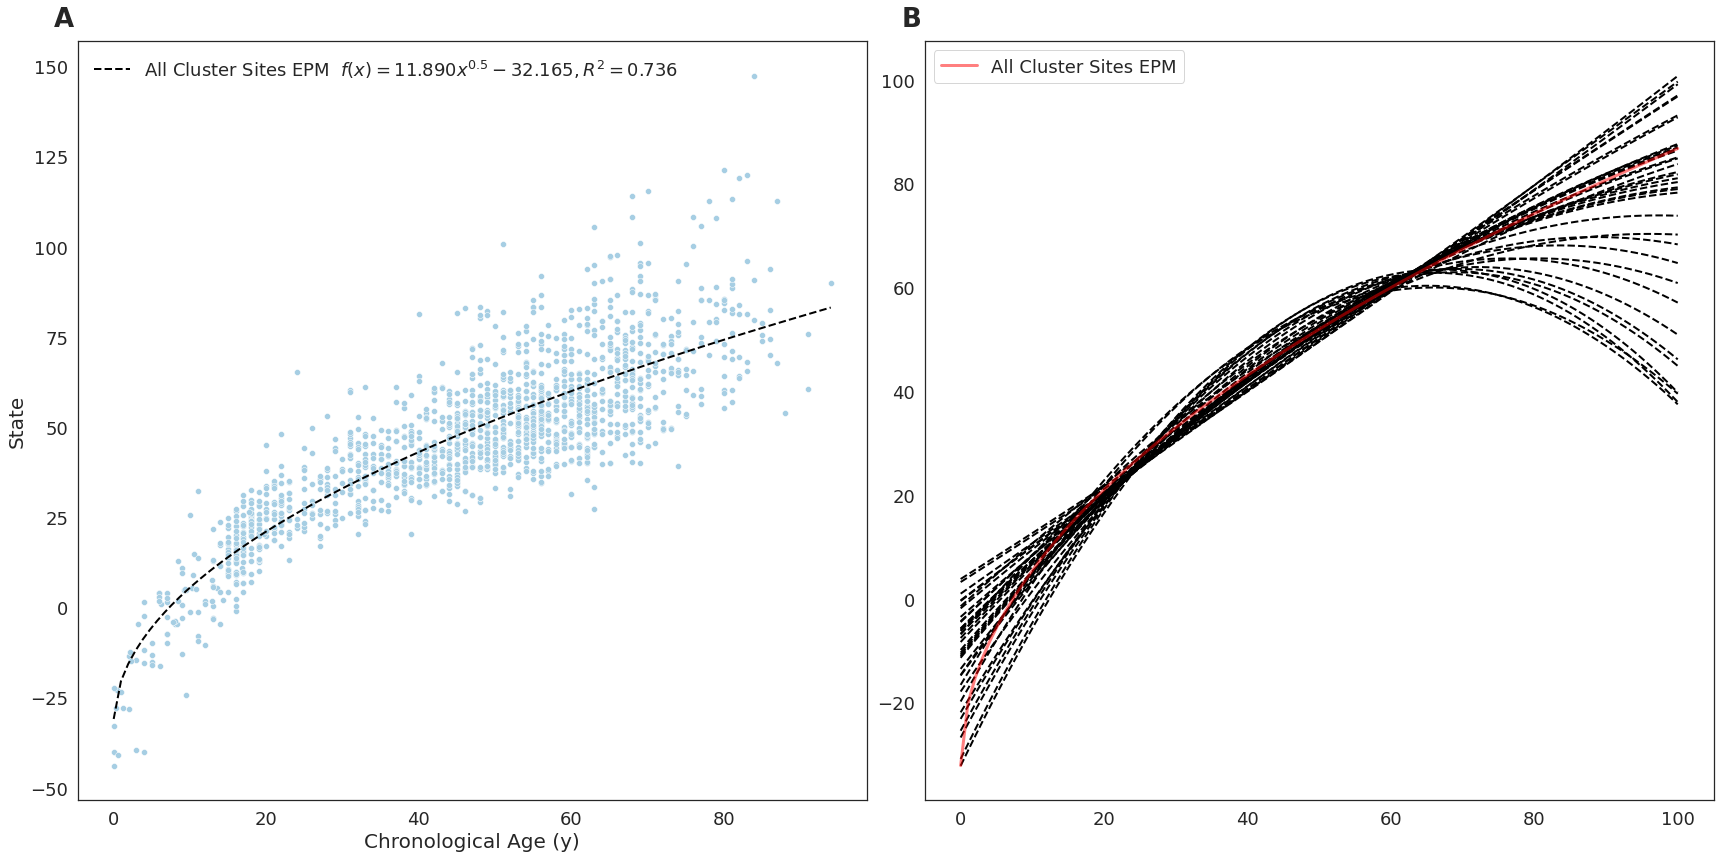

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))

plot_epm({'popt':epm_popt}, {}, ax[0], 'All Cluster Sites EPM', ages=train_ages, states=epm_states)

plot_age_state_trends(cluster_epms, ax[1], r2_filter=.4)

age_range = np.linspace(0, 100, 100)
expected_range = basic_func(age_range, *epm_popt)
ax[1].plot(age_range, expected_range, 'r-', lw=3, alpha=.5, label='All Cluster Sites EPM')
ax[1].legend()

ax[0].text(-0.03, 1.02, f'A', transform=ax[0].transAxes, fontsize=26, weight='bold')
ax[1].text(-0.03, 1.02, f'B', transform=ax[1].transAxes, fontsize=26, weight='bold')

plt.tight_layout()
plt.savefig('figures/Figure3.png', dpi=300)
plt.show()

In [138]:
len(cluster_epms)

55

In [139]:
def get_cell_type_corr(states, cell_estimates, label=''):
    cell_corrs = {}
    for cell_type in list(cell_estimates):
        cell_corrs[f'{label}{cell_type}'] = stats.pearsonr(states, cell_estimates[cell_type].values)[0]
    return cell_corrs

In [140]:
cluster_count = 0

cluster_summaries_raw = {}

for cluster, cluster_info in cluster_epms.items():
    cluster_count += 1
    cluster_summary = dict(R2=cluster_info['r2'], MAE=cluster_info['mae'], ClusterSize=len(site_labels[cluster]),
                           StateSexCorr=stats.pearsonr(cluster_info['states'], train_sex)[0],
                           StateSexDiffCorr=stats.pearsonr(cluster_info['states'] - cluster_info['expected_states'], train_sex)[0],
                           StateAgeCorr=stats.pearsonr(cluster_info['states'], train_ages)[0],
                           LMR2=cluster_info['lm_r2'], LMMAE=cluster_info['lm_mae'], 
                           EASexCorr=stats.pearsonr(cluster_info['lm_clust_values'], train_sex)[0],
                           EASexDiffCorr=stats.pearsonr(cluster_info['lm_clust_values'] - train_ages, train_sex)[0])
    cluster_summary.update(get_cell_type_corr(cluster_info['states'], train_cells))
    cluster_summary.update(get_cell_type_corr(cluster_info['states'] - cluster_info['expected_states'], train_cells, 'diff_'))
    cluster_summary.update(get_cell_type_corr(cluster_info['lm_clust_values'], train_cells, 'lm_'))
    cluster_summary.update(get_cell_type_corr(cluster_info['lm_clust_values'] - train_ages, train_cells, 'lm_diff_'))
    center_x, center_y = train_pcs[:,0][cluster_centers[cluster]], train_pcs[:,1][cluster_centers[cluster]]
    cluster_summary.update(dict(center_x=center_x, center_y=center_y))
    cluster_summaries_raw[cluster] = cluster_summary

In [141]:
cluster_summaries = pd.DataFrame(cluster_summaries_raw).T

In [142]:
cluster_summaries['AbsStateSexCorr'] = abs(cluster_summaries['StateSexCorr'])

In [143]:
def plot_epm_clusters(all_cluster_info, all_cluster_stats, all_cluster_states,
                      cluster_hue=None, cluster_style=None, ages=None):
    columns = 3
    rows = math.ceil(len(all_cluster_states) / 3)
    figsize=(36, rows * 12)
    if rows:
        fig, ax = plt.subplots(rows, columns, figsize=figsize)
    for count, cluster in tqdm(enumerate(all_cluster_states)):
        row = 0 
        if count:
            row = int(count / columns)
        column = count % columns
        cluster_epm_info = all_cluster_info[cluster]
        cluster_epm_stats = all_cluster_stats[cluster]
        states = all_cluster_states[cluster]
        if rows > 1:
            clust_ax = ax[row, column]
        else:
            clust_ax = ax[column]
        plot_epm(cluster_epm_info, cluster_epm_stats, clust_ax, 
                 cluster_label=f'Cluster {str(cluster)}, x={cluster_epm_stats["center_x"]: .3f}, y={cluster_epm_stats["center_y"]: .3f}, sites={cluster_epm_info["cluster_size"]}:', 
                 ages=ages, cluster_hue=cluster_hue, cluster_style=cluster_style, states=states)
    return fig, ax

0it [00:00, ?it/s]

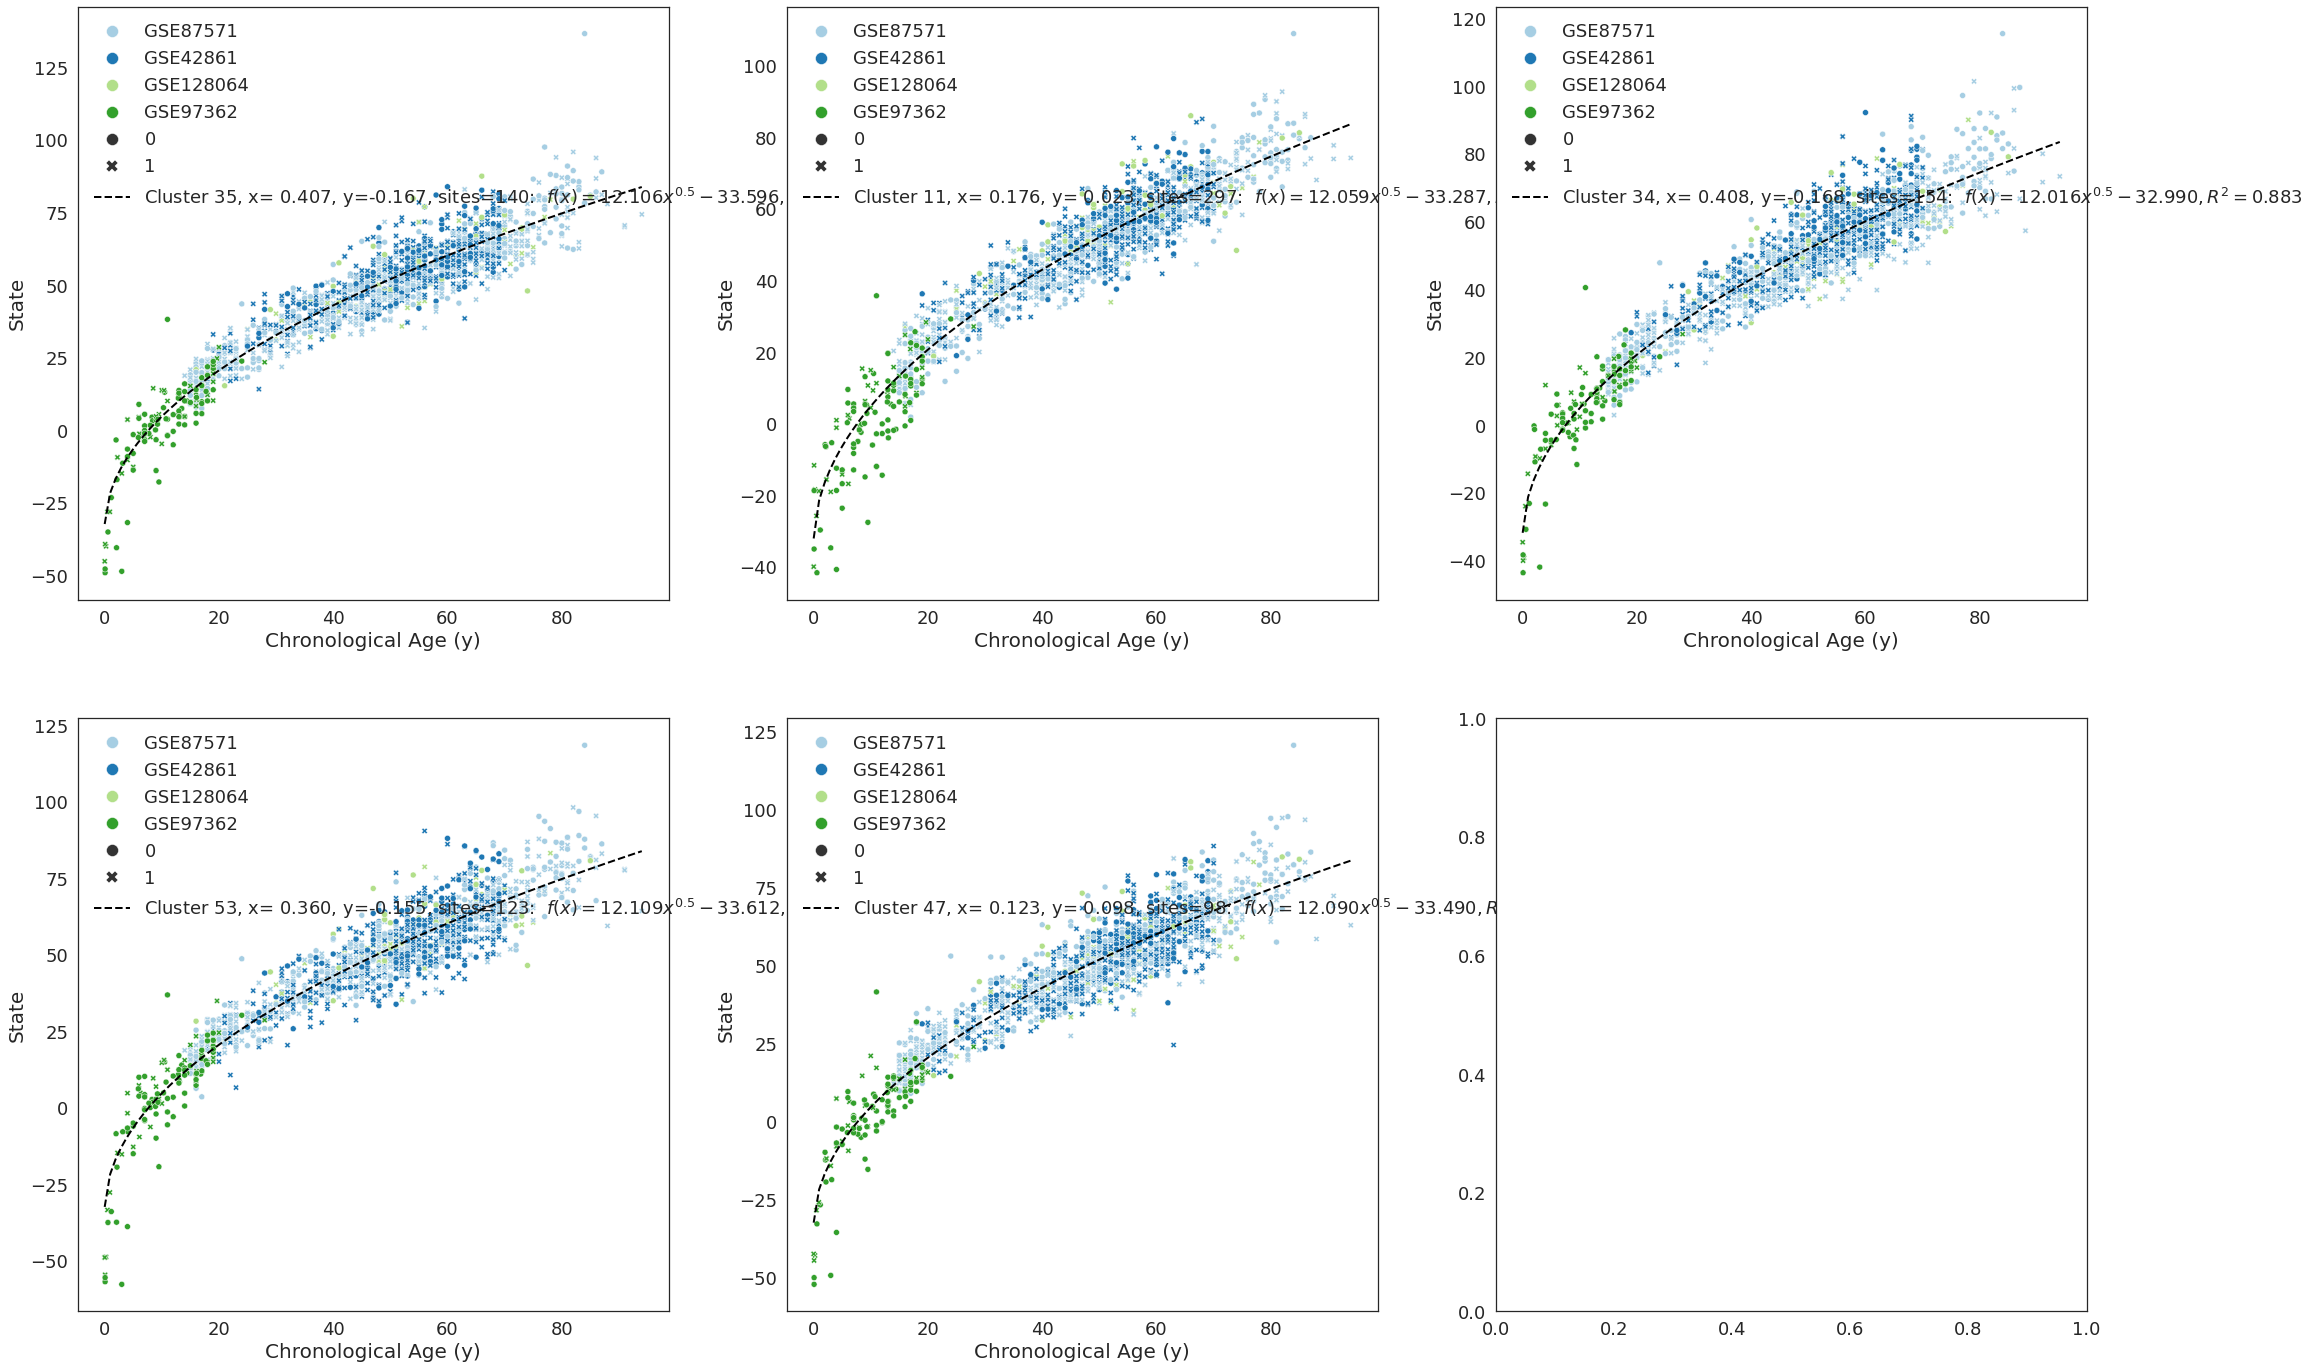

In [144]:
fig, ax = plot_epm_clusters(cluster_epms, cluster_summaries_raw, 
                            {clust: clust_info['states'] for clust, clust_info in cluster_epms.items() if clust_info['mae'] < 6},
                            ages=train_ages,
                            cluster_hue=[sample_meta[sample]['experiment_id'] for sample in list(train_matrix)],
                            cluster_style=train_sex)

In [145]:
test_clusters = list(cluster_summaries.loc[cluster_summaries['MAE'] < 6].index)

In [146]:
combined_clust_sites = np.array(sum([site_labels[clust] for clust in test_clusters], []))

In [147]:
combined_epm, combined_train_states = fit_epm(epm_matrix.values[combined_clust_sites,:], train_ages)
combined_popt, _, combined_train_expected_states = fit_trend(train_ages, combined_train_states)
combined_r2 = r2(combined_train_states, combined_train_expected_states)
combined_mae = mae(combined_train_states, combined_train_expected_states)

In [148]:
combined_lm = fit_lm(epm_matrix.values[combined_clust_sites,:], train_ages, default_en_kwargs)

In [149]:
combined_lm_popt, _, _ = fit_trend(train_ages, combined_lm[1], func=lin_func)

In [150]:
combined_info = {'popt':combined_popt}

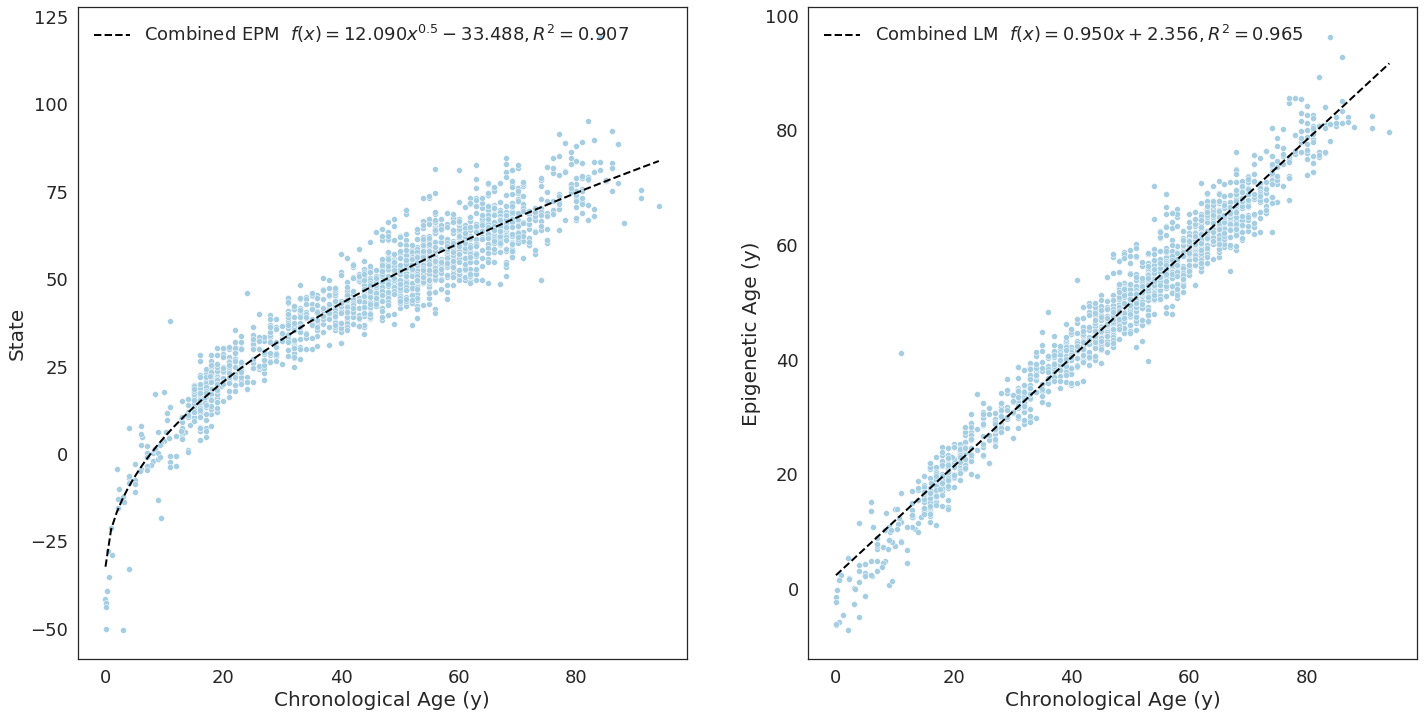

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))

plot_epm(combined_info, {}, ax[0], cluster_label='Combined EPM', ages=train_ages, states=combined_train_states)
plot_lm(combined_lm_popt, ax[1], label='Combined LM', ages=train_ages, eas=combined_lm[1])

plt.show()

In [152]:
all_lm, all_lm_values = fit_lm(epm_matrix.values, train_ages, default_en_kwargs)

### Load Test Data

In [153]:
test_files = [get_sample_matrix_info(blood_meta[sample]) for sample in test_samples]
test_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in test_files}

In [154]:
test_row_labels = list(set(lm_labels + epm_sites))

In [155]:
test_methylation, test_header, test_rows = retrieve_sample_methylation(test_files, n_jobs=4, 
                                                                       verbosity=10, rows=test_row_labels, quantile_norm=quant)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  25 out of  29 | elapsed:  1.5min remaining:   14.8s
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:  1.7min finished


In [156]:
cleaned_test_header = [x.replace('"', '').split('_')[0] for x in test_header][1:]

In [157]:
test_matrix = pd.DataFrame(test_methylation, columns = cleaned_test_header, index=test_rows)
test_lm_matrix = test_matrix.loc[lm_labels]
test_epm_matrix = test_matrix.loc[epm_matrix.index]

### Test predictions 

In [158]:
test_ages = np.array([blood_meta[sample]['age yrs'] for sample in list(test_matrix)])

In [159]:
test_sex = np.array([blood_meta[sample]['proc_predictedSex'] for sample in list(test_matrix)])
test_sex = np.array([1 if sex == 'F' else 0 for sex in test_sex])

In [160]:
test_cells = []

for ct in cell_types:
    test_cells.append([blood_meta[sample][ct] for sample in list(test_matrix)])

In [161]:
test_cells = pd.DataFrame(test_cells, columns=list(test_matrix), index=cell_types).T

In [162]:
test_predictions = {}

for clust_label, clust in cluster_epms.items():
    cluster_sites = site_labels[clust_label]
    epm_states = clust['epm'].predict(test_epm_matrix.values[cluster_sites,:])
    lm_ea = clust['clust_lm'].predict(test_epm_matrix.values[cluster_sites,:].T)
    test_predictions[clust_label] = dict(epm_states=epm_states, lm_ea=lm_ea)

0it [00:00, ?it/s]

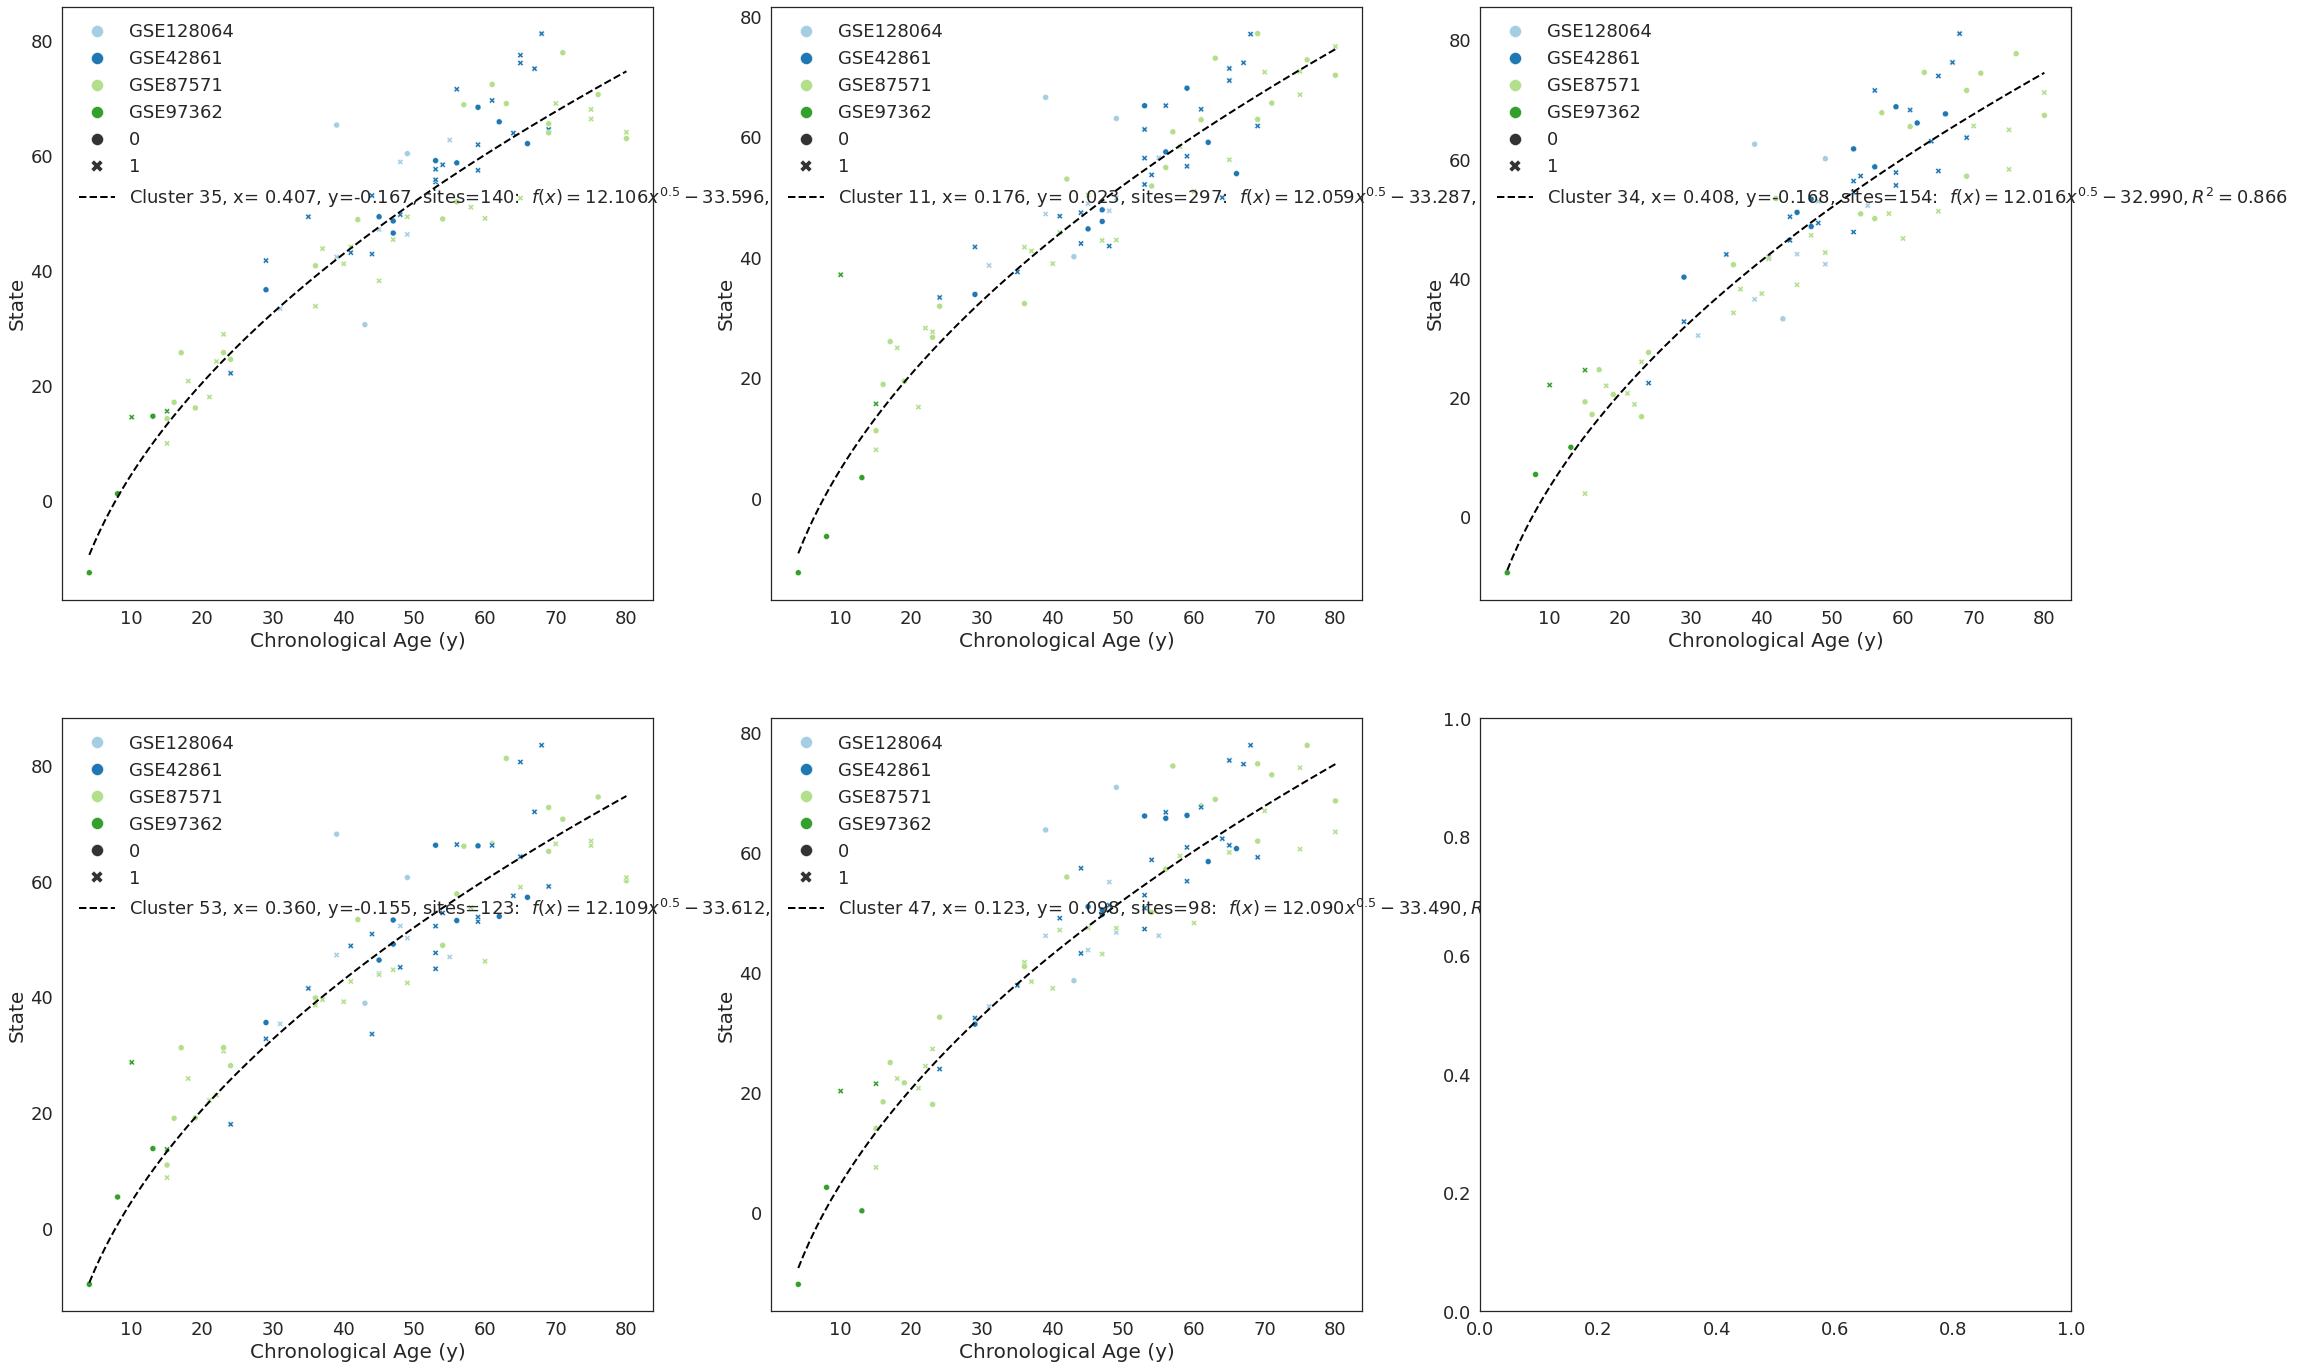

In [163]:
fig, ax = plot_epm_clusters(cluster_epms, cluster_summaries_raw, 
                            {clust: test_predictions[clust]['epm_states'] for clust in test_clusters},
                            ages=test_ages,
                            cluster_hue=[sample_meta[sample]['experiment_id'] for sample in list(test_matrix)],
                            cluster_style=test_sex)

In [164]:
combined_test_states = combined_epm.predict(test_epm_matrix.values[combined_clust_sites])

In [165]:
combined_test_eas = combined_lm[0].predict(test_epm_matrix.values[combined_clust_sites,:].T)

In [166]:
test_full_lm_predictions = get_sparse_model_predictions(test_matrix.loc[lm_labels].values, sparse_full_lm) 

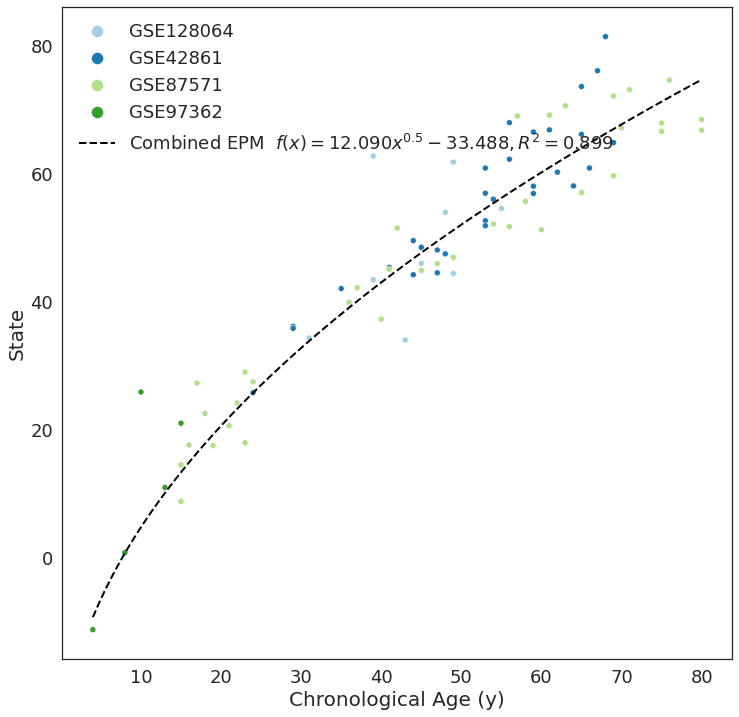

In [167]:
fig, ax = plt.subplots(figsize=(12,12))

plot_epm(combined_info, {}, ax, cluster_label='Combined EPM', ages=test_ages, states=combined_test_states,
         cluster_hue=[sample_meta[sample]['experiment_id'] for sample in list(test_matrix)])

plt.show()

## Validation Predictions

In [168]:
all_blood_meta = {sample: info for sample, info in sample_meta.items() if sample_check(info, relative_intensity_filter=blood_450k_fit)}

In [169]:
all_train_exps = set(train_exps)

In [170]:
validation_meta = {sample: info for sample, info in all_blood_meta.items() if info['experiment_id'] not in all_train_exps}

In [171]:
len(validation_meta)

4082

In [172]:
validation_files = [get_sample_matrix_info(info) for info in validation_meta.values()]
validation_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in validation_files}

In [173]:
val_methylation, val_header, val_rows = retrieve_sample_methylation(validation_files, n_jobs=16, 
                                                                    verbosity=10, rows=test_row_labels,
                                                                    quantile_norm=quant)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:  5.3min
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  6.3min
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:  8.3min
[Parallel(n_jobs=16)]: Done  71 out of  92 | elapsed: 11.0min remaining:  3.2min
[Parallel(n_jobs=16)]: Done  81 out of  92 | elapsed: 11.7min remaining:  1.6min
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed: 12.6min finished


In [174]:
cleaned_val_header = [x.replace('"', '').split('_')[0] for x in val_header][1:]

In [175]:
val_matrix = pd.DataFrame(val_methylation, columns = cleaned_val_header, index=val_rows)

In [176]:
val_lm_matrix = val_matrix.loc[lm_labels]
val_epm_matrix = val_matrix.loc[epm_matrix.index]

In [177]:
val_ages = np.array([sample_meta[sample]['age yrs'] for sample in list(val_matrix)])

In [178]:
val_sex = np.array([1 if sample_meta[sample]['proc_predictedSex'] == 'F' else 0 for sample in list(val_matrix)])

In [179]:
val_cells = []

for ct in cell_types:
    val_cells.append([sample_meta[sample][ct] for sample in list(val_matrix)])

In [180]:
val_cells = pd.DataFrame(val_cells, columns=list(val_matrix), index=cell_types).T

In [181]:
val_predictions = {}

for clust_label, clust in cluster_epms.items():
    cluster_sites = site_labels[clust_label]
    epm_states = clust['epm'].predict(val_epm_matrix.values[cluster_sites,:])
    lm_ea = clust['clust_lm'].predict(val_epm_matrix.values[cluster_sites,:].T)
    val_predictions[clust_label] = dict(epm_states=epm_states, lm_ea=lm_ea)

In [182]:
combined_val_states = combined_epm.predict(val_epm_matrix.values[combined_clust_sites,:])

In [183]:
val_full_lm_predictions = get_sparse_model_predictions(val_matrix.loc[lm_labels].values, sparse_full_lm) 

In [184]:
combined_val_eas = combined_lm[0].predict(val_epm_matrix.values[combined_clust_sites,:].T)

val_all_eas = all_lm.predict(val_epm_matrix.values.T)

### Plot Age / State Models

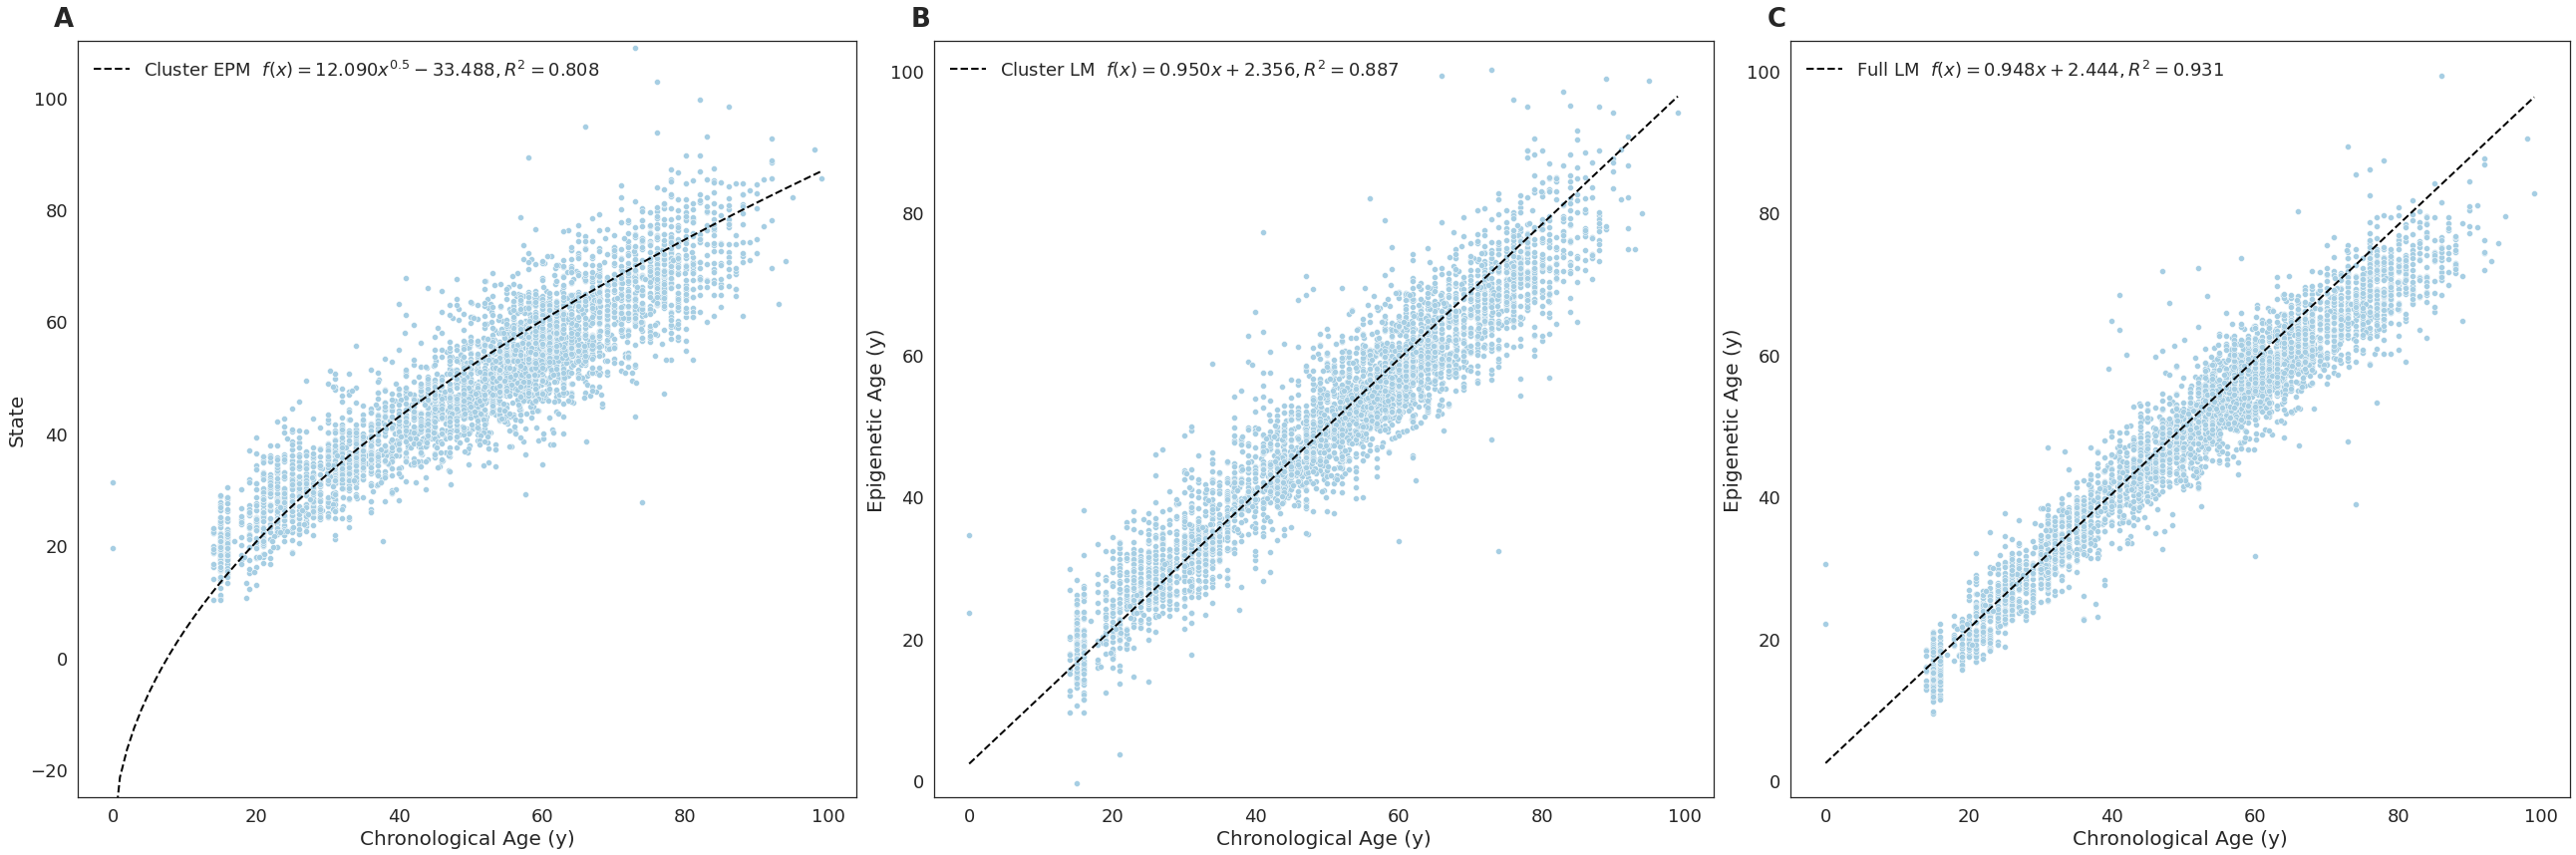

In [185]:
fig, ax = plt.subplots(1,3, figsize=(36,12))

plot_epm(combined_info, {}, ax[0], cluster_label='Cluster EPM', ages=val_ages, states=combined_val_states)
ax[0].set_ylim(-25, 110)
plot_lm(combined_lm_popt, ax[1], label='Cluster LM', ages=val_ages, eas=combined_val_eas)
plot_lm(full_lm_popt, ax[2], label='Full LM', ages=val_ages, eas=val_full_lm_predictions)
ax[1].set_ylim(ax[2].get_ylim())


ax[0].text(-0.03, 1.02, f'A', transform=ax[0].transAxes, fontsize=26, weight='bold')
ax[1].text(-0.03, 1.02, f'B', transform=ax[1].transAxes, fontsize=26, weight='bold')
ax[2].text(-0.03, 1.02, f'C', transform=ax[2].transAxes, fontsize=26, weight='bold')

plt.tight_layout()
plt.savefig('figures/Figure4.png', dpi=300)
plt.show()

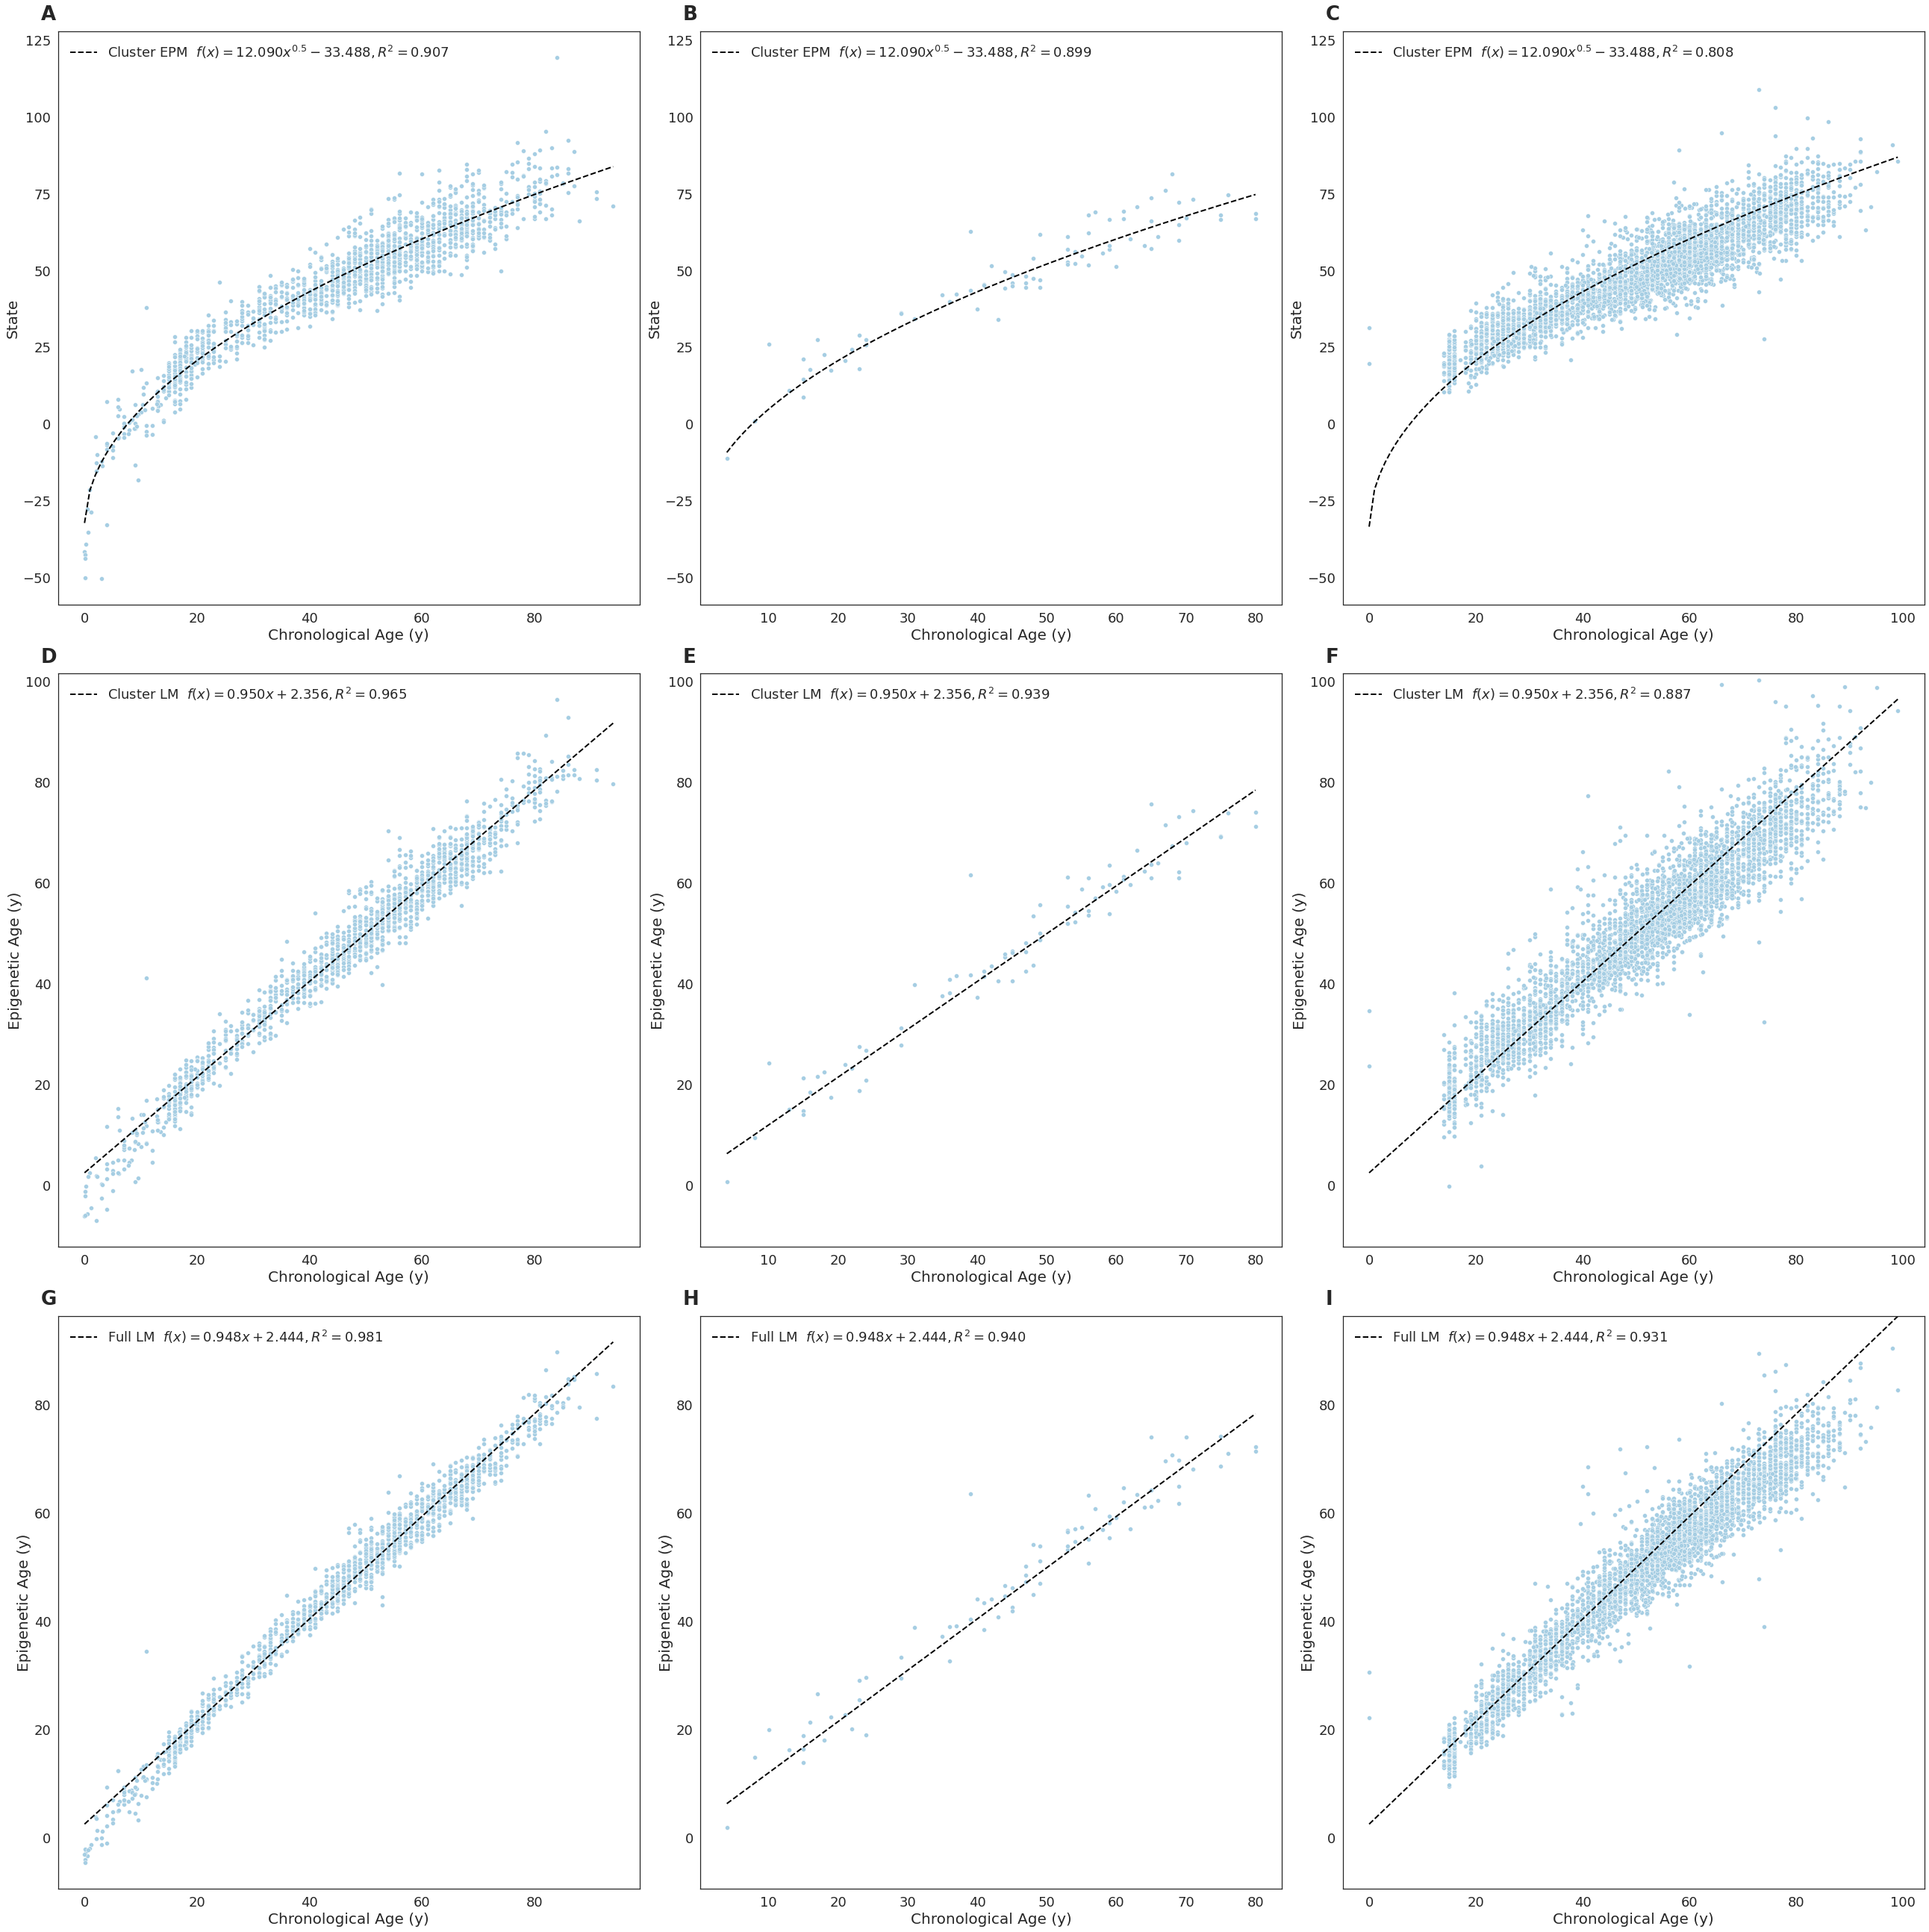

In [186]:
fig, ax = plt.subplots(3,3, figsize=(36,36))

plot_epm(combined_info, {}, ax[0,0], cluster_label='Cluster EPM', ages=train_ages, states=combined_train_states)
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[0,2].set_ylim(ax[0,0].get_ylim())
plot_epm(combined_info, {}, ax[0,1], cluster_label='Cluster EPM', ages=test_ages, states=combined_test_states)
plot_epm(combined_info, {}, ax[0,2], cluster_label='Cluster EPM', ages=val_ages, states=combined_val_states)

plot_lm(combined_lm_popt, ax[1,0], label='Cluster LM', ages=train_ages, eas=combined_lm[1])
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,2].set_ylim(ax[1,0].get_ylim())
plot_lm(combined_lm_popt, ax[1,1], label='Cluster LM', ages=test_ages, eas=combined_test_eas)
plot_lm(combined_lm_popt, ax[1,2], label='Cluster LM', ages=val_ages, eas=combined_val_eas)

plot_lm(full_lm_popt, ax[2, 0], label='Full LM', ages=train_ages, eas=train_lm_predictions)
ax[2,1].set_ylim(ax[2,0].get_ylim())
ax[2,2].set_ylim(ax[2,0].get_ylim())
plot_lm(full_lm_popt, ax[2, 1], label='Full LM', ages=test_ages, eas=test_full_lm_predictions)
plot_lm(full_lm_popt, ax[2, 2], label='Full LM', ages=val_ages, eas=val_full_lm_predictions)

ax[0,0].text(-0.03, 1.02, f'A', transform=ax[0,0].transAxes, fontsize=26, weight='bold')
ax[0,1].text(-0.03, 1.02, f'B', transform=ax[0,1].transAxes, fontsize=26, weight='bold')
ax[0,2].text(-0.03, 1.02, f'C', transform=ax[0,2].transAxes, fontsize=26, weight='bold')

ax[1,0].text(-0.03, 1.02, f'D', transform=ax[1,0].transAxes, fontsize=26, weight='bold')
ax[1,1].text(-0.03, 1.02, f'E', transform=ax[1,1].transAxes, fontsize=26, weight='bold')
ax[1,2].text(-0.03, 1.02, f'F', transform=ax[1,2].transAxes, fontsize=26, weight='bold')

ax[2,0].text(-0.03, 1.02, f'G', transform=ax[2,0].transAxes, fontsize=26, weight='bold')
ax[2,1].text(-0.03, 1.02, f'H', transform=ax[2,1].transAxes, fontsize=26, weight='bold')
ax[2,2].text(-0.03, 1.02, f'I', transform=ax[2,2].transAxes, fontsize=26, weight='bold')

plt.tight_layout()
plt.savefig('figures/S.Figure1.png', dpi=300)

plt.show()

### Check for Phenotype Associations 

In [187]:
def get_exp_phenotypes(meta_data, states, samples, expected):
    exp_df = pd.DataFrame({sample:meta_data[sample] for sample in samples}).T
    exp_df['States'] = states
    exp_df['Diff'] = states - expected
    exp_df['AgeYrs'] = exp_df['age yrs'].values
    exp_df['SqrtAge'] = np.sqrt(exp_df['AgeYrs'].values.astype('float'))
    exp_df['ProcSex'] = [0 if sex == 'M' else 1 for sex in exp_df['proc_predictedSex'].values]
    exp_df['AgeSex'] = exp_df['age yrs'] * exp_df['ProcSex']
    exp_cell_pcs = cell_pca.transform(exp_df[cell_types].values)
    for col in range(exp_cell_pcs.shape[1]):
        exp_df[f'PC{col + 1}'] = exp_cell_pcs[:,col]
    return exp_df

In [188]:
def get_design_matrices(y_cat=None, x_cats=[], exp_df=None, fit_intercept=False):
    intercept = ' + 0' if not fit_intercept else ''
    r_df = exp_df[[y_cat] + x_cats]
    r_df = r_df.astype('float')
    xs = ' + '.join(x_cats)
    y, X = dmatrices(f'{y_cat} ~ {xs}{intercept}', data=r_df, return_type='dataframe')
    return y, X

In [189]:
def fit_exp_model(y_cat=None, x_cats=None, states=None, samples=None, meta_data=None, expected=None, fit_intercept=False):
    exp_df = get_exp_phenotypes(meta_data, states, samples, expected)
    y, X = get_design_matrices(y_cat, x_cats, exp_df, fit_intercept=fit_intercept)
    results = sm.OLS(y, X).fit()
    return results

In [190]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

In [191]:
def format_res(res, exp, model_type, sex_dist):
    model_info = {'ExperimentID':exp, 'ModelType':model_type,
                  'SexDist':sex_dist} 
    for key, value in res.summary2().tables[1].T.to_dict().items():
        for cat in ['Coef.', 'Std.Err.', 't', 'P>|t|']:
            model_info[f'{key} {cat}'] = value[cat]
    for table in [0, 2]:
        for x in res.summary2().tables[table].values:
            for y in range(int(len(x) / 2)):
                model_info[x[y * 2]] = convert_to_float(x[y * 2 + 1])
    return model_info

In [192]:
val_states = combined_val_states
val_eas = combined_val_eas
val_popt = combined_popt

In [193]:
x_cats = ['AgeYrs', 'ProcSex', 
          'PC1', 'PC2', 'PC3',
          'SqrtAge']

In [194]:
all_res = {}

for exp in tqdm(validation_exps):
    _samples = [sample for sample in list(val_matrix) if validation_meta[sample]['experiment_id'] == exp]
    if not _samples:
        continue
    _ages = np.array([validation_meta[sample]['age yrs'] for sample in list(val_matrix) if validation_meta[sample]['experiment_id'] == exp])
    _states = [state for state, sample in zip(val_states, list(val_matrix)) if validation_meta[sample]['experiment_id'] == exp]
    _expected = basic_func(_ages, *val_popt)
    _eas = np.array([state for state, sample in zip(val_eas, list(val_matrix)) if validation_meta[sample]['experiment_id'] == exp])
    _full_eas = np.array([state for state, sample in zip(val_full_lm_predictions, list(val_matrix)) if validation_meta[sample]['experiment_id'] == exp])
    # fit sm OLS
    _sex = np.array([0 if validation_meta[sample]['proc_predictedSex'] == 'M' else 1 for sample in list(val_matrix) if validation_meta[sample]['experiment_id'] == exp])
    _sex_dist = sum(_sex) / len(_sex)
    fit_cats = x_cats
    if _sex_dist > .7:
        fit_cats = [cat for cat in x_cats if cat != 'ProcSex']
    _state_res = fit_exp_model(y_cat='States', x_cats=fit_cats, states=_states, samples=_samples, 
                               meta_data=validation_meta, expected=_expected, fit_intercept=True)
    _ea_res = fit_exp_model(y_cat='States', x_cats=fit_cats, states=_eas, samples=_samples, 
                            meta_data=validation_meta, expected=_ages, fit_intercept=True)
    _full_ea_res = fit_exp_model(y_cat='States', x_cats=fit_cats, states=_full_eas, samples=_samples, 
                                 meta_data=validation_meta, expected=_ages, fit_intercept=True)
    all_res[f'{exp}_epm'] = format_res(_state_res, exp, 'epm', _sex_dist)
    all_res[f'{exp}_lm'] = format_res(_ea_res, exp, 'lm', _sex_dist)
    all_res[f'{exp}_full_lm'] = format_res(_full_ea_res, exp, 'flm', _sex_dist)

  0%|          | 0/21 [00:00<?, ?it/s]

In [195]:
model_df = pd.DataFrame(all_res).T

In [196]:
p_val_cats = [f'{cat} P>|t|' for cat in x_cats] 
coef_cats = [f'{cat} Coef' for cat in x_cats]

plot_cats = ['ExperimentID', 'ModelType']

In [197]:
single_var_values = [] 

for cat in x_cats:
    for site_type in ['P>|t|', 'Coef.']:
        p_df = model_df[['ExperimentID', 'ModelType', f'{cat} {site_type}']].copy()
        p_df['cat'] = np.array([cat for _ in range(p_df.shape[0])])
        p_df['SiteType'] = [site_type for _ in range(p_df.shape[0])]
        single_var_values.extend(p_df.values)

In [198]:
reg_var_df = pd.DataFrame(single_var_values, columns=['ExperimentID', 'ModelType', 'Value', 'Category', 'ValueType'])

In [199]:
for model in ['epm', 'lm', 'flm']:
    _model_df = reg_var_df.loc[reg_var_df['ModelType'] == model].loc[reg_var_df['Category'] == 'ProcSex'].loc[reg_var_df['ValueType'] == 'P>|t|']
    print(np.nanmean(_model_df['Value'].values), np.nanmedian(_model_df['Value'].values), 
          len([x for x in _model_df['Value'].values if not np.isnan(x)]), len([x for x in _model_df['Value'].values if not np.isnan(x) and x < 0.05 / 3]))

0.14682271810863623 0.0012510134217970203 11 7
0.25160042055256837 0.056766639083861335 11 3
0.3756816980065411 0.21684473913879168 11 0


In [200]:
reg_var_df['-log10(p-val)'] = -1 * np.log10(reg_var_df['Value'].values)

/tmp/ipykernel_10729/3027993497.py:1: RuntimeWarning: invalid value encountered in log10
  reg_var_df['-log10(p-val)'] = -1 * np.log10(reg_var_df['Value'].values)


In [201]:
plot_label_conversion = {'ProcSex': 'Sex', 'AgeSex': 'Age*Sex', 'PC1': 'Cell Type PC1', 'PC2': 'Cell Type PC2',
                   'PC3': 'Cell Type PC3', 'PC4': 'Cell Type PC4', 'PC5': 'Cell Type PC5', 
                   'proc_CD8T': 'CD8T','proc_CD4T': 'CD4T','proc_NK': 'NK',
                   'proc_Bcell': 'B Cell','proc_Mono': 'Monocyte',
                   'proc_Gran': 'Granulocyte', }

In [203]:
reg_var_df

,ExperimentID,ModelType,Value,Category,ValueType,-log10(p-val)
0,GSE69138,epm,6.528204e-02,AgeYrs,P>|t|,1.185206
1,GSE69138,lm,5.996960e-03,AgeYrs,P>|t|,2.222069
2,GSE69138,flm,8.441797e-02,AgeYrs,P>|t|,1.073565
3,GSE156994,epm,9.592833e-03,AgeYrs,P>|t|,2.018053
4,GSE156994,lm,2.259873e-07,AgeYrs,P>|t|,6.645916
...,...,...,...,...,...,...
499,GSE43976,lm,3.439605e+01,SqrtAge,Coef.,-1.536509
500,GSE43976,flm,5.339372e+00,SqrtAge,Coef.,-0.727490
501,GSE73103,epm,9.051387e+00,SqrtAge,Coef.,-0.956715
502,GSE73103,lm,5.339726e+00,SqrtAge,Coef.,-0.727519


/tmp/ipykernel_10729/1208033546.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], dodge=True, color='k', size=3)
/tmp/ipykernel_10729/1208033546.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], dodge=True, color='k', size=3)
/tmp/ipykernel_10729/1208033546.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(['Cluster EPM', 'Cluster LM', 'Full LM'])

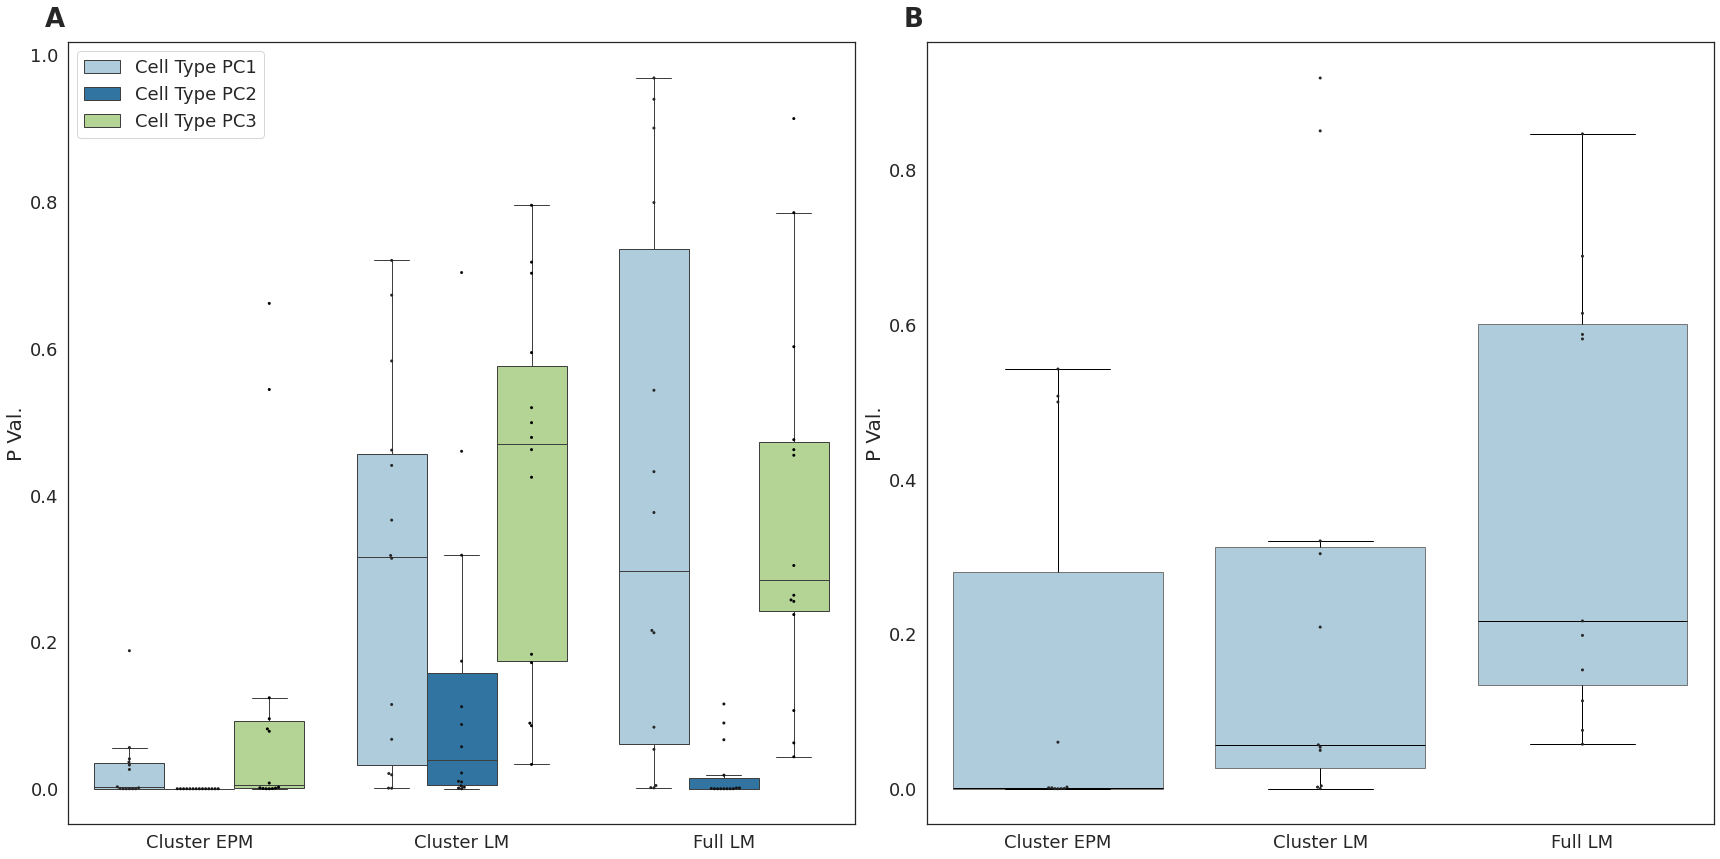

In [202]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))

plot_cats = [cat for cat in x_cats if cat not in {'AgeYrs', 'SqrtAge', 'ProcSex'}]
legend_labels = [plot_label_conversion[cat] for cat in plot_cats]


sns.boxplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], showfliers=False)
sns.swarmplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], dodge=True, color='k', size=3)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:len(plot_cats)], labels[:len(plot_cats)])



sns.boxplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], showfliers=False)
sns.swarmplot(x='ModelType', y='Value', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], dodge=True, color='k', size=3)


ax[1].legend_ = None


_ = plt.setp(ax[1].artists, edgecolor = 'k', facecolor='w')
_ = plt.setp(ax[1].artists, edgecolor = 'k', facecolor='w')

_ = plt.setp(ax[1].lines, color='k')
_ = plt.setp(ax[1].lines, color='k')

ax[0].text(-0.03, 1.02, f'A', transform=ax[0].transAxes, fontsize=26, weight='bold')
ax[1].text(-0.03, 1.02, f'B', transform=ax[1].transAxes, fontsize=26, weight='bold')

for count, label in enumerate(legend_labels):
    ax[0].legend_.texts[count].set_text(label)


ax[0].set_ylabel('P Val.')
ax[1].set_ylabel('P Val.')


for axx in ax:
    axx.set_xlabel('')
    axx.set_xticklabels(['Cluster EPM', 'Cluster LM', 'Full LM'])

plt.tight_layout()
plt.savefig('figures/Figure5.png', dpi=300)
plt.show()

/tmp/ipykernel_10729/1287093642.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], dodge=True, color='k', size=3)
/tmp/ipykernel_10729/1287093642.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], dodge=True, color='k', size=3)
/tmp/ipykernel_10729/1287093642.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(['Cluster EPM', 'Cluster 

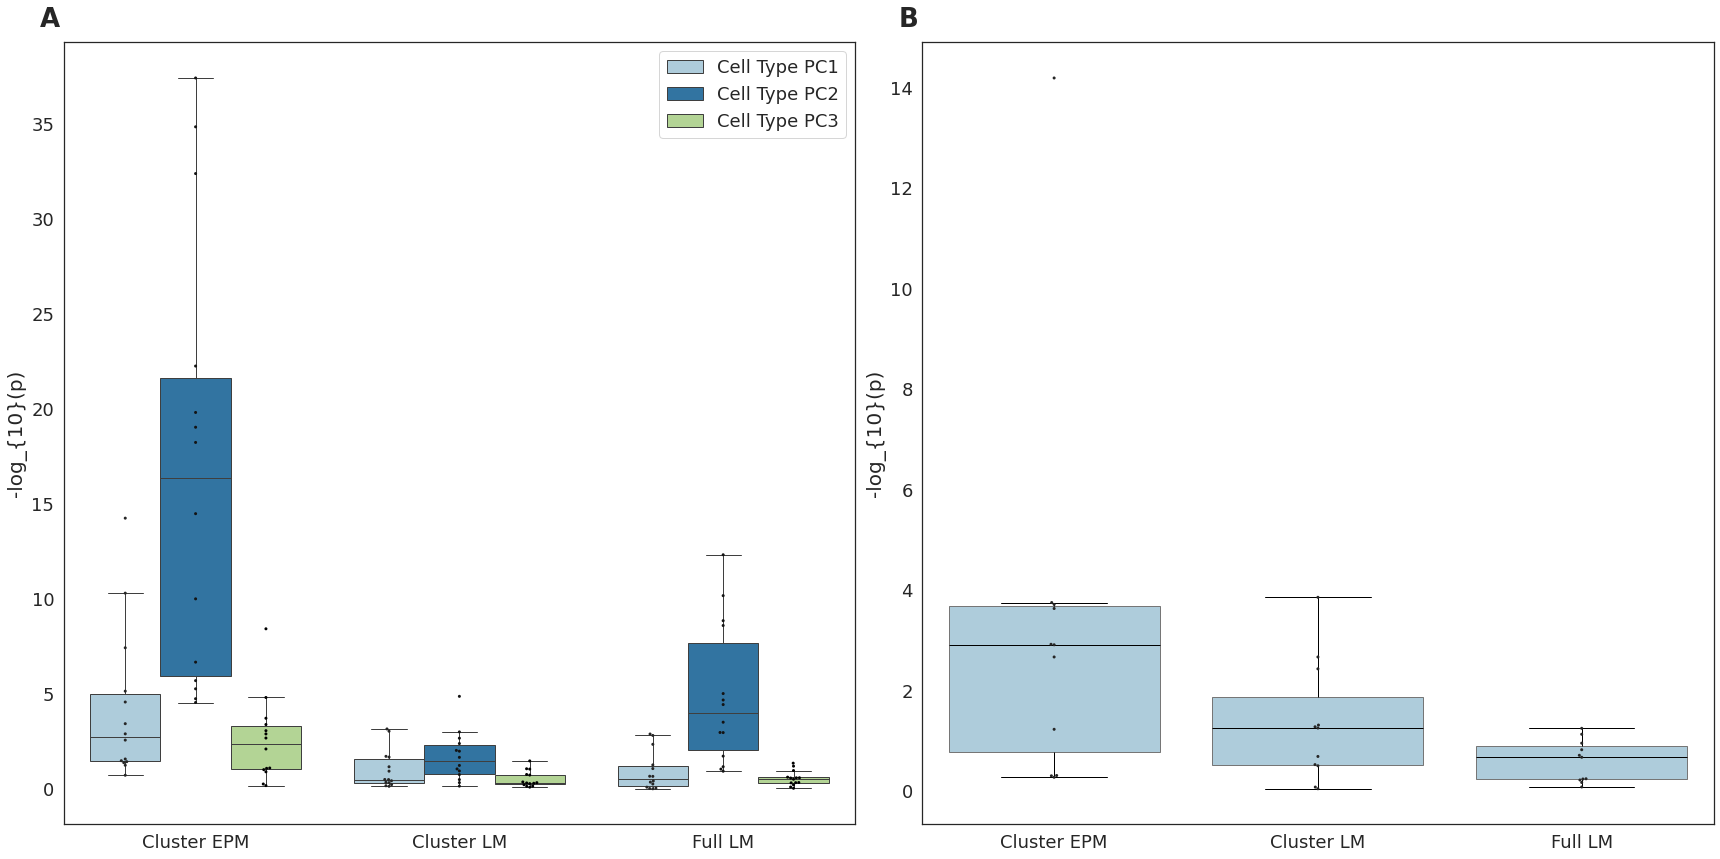

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))

plot_cats = [cat for cat in x_cats if cat not in {'AgeYrs', 'SqrtAge', 'ProcSex'}]
legend_labels = [plot_label_conversion[cat] for cat in plot_cats]


sns.boxplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], showfliers=False)
sns.swarmplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'].isin(plot_cats)], ax=ax[0], dodge=True, color='k', size=3)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:len(plot_cats)], labels[:len(plot_cats)])



sns.boxplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], showfliers=False)
sns.swarmplot(x='ModelType', y='-log10(p-val)', hue='Category', data=reg_var_df.loc[reg_var_df['ValueType'] == 'P>|t|'].loc[reg_var_df['Category'] == 'ProcSex'], ax=ax[1], dodge=True, color='k', size=3)


ax[1].legend_ = None


_ = plt.setp(ax[1].artists, edgecolor = 'k', facecolor='w')
_ = plt.setp(ax[1].artists, edgecolor = 'k', facecolor='w')

_ = plt.setp(ax[1].lines, color='k')
_ = plt.setp(ax[1].lines, color='k')

ax[0].text(-0.03, 1.02, f'A', transform=ax[0].transAxes, fontsize=26, weight='bold')
ax[1].text(-0.03, 1.02, f'B', transform=ax[1].transAxes, fontsize=26, weight='bold')

for count, label in enumerate(legend_labels):
    ax[0].legend_.texts[count].set_text(label)


ax[0].set_ylabel('-log_{10}(p)')
ax[1].set_ylabel('-log_{10}(p)')


for axx in ax:
    axx.set_xlabel('')
    axx.set_xticklabels(['Cluster EPM', 'Cluster LM', 'Full LM'])

plt.tight_layout()
plt.savefig('figures/Figure5.png', dpi=300)
plt.show()